# A Golden Thread through Time
## The chemodynamical memory of a major merger in a simulated NIHAO-UHD Milky Way analogue

Author: Sven Buder (ANU), sven.buder@anu.edu.au  
GitHub repository: https://github.com/svenbuder/gse_nihaouhd  
arXiv: YYMM.NNNNN

# Preamble

In [88]:
# Import packages
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm, LinearSegmentedColormap,Normalize
from matplotlib.patches import Patch, Rectangle, Circle
from matplotlib.gridspec import GridSpec
from scipy.optimize import curve_fit
from astropy.table import Table, join
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
from scipy.stats import gaussian_kde, binned_statistic_2d, skew, norm, skewnorm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RBFInterpolator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple
from hyppo.ksample import Energy

# Set the seed for reproducibility
np.random.seed(8123)

In [ ]:
def format_with_uncertainty(value, uncertainty):
    if uncertainty == 0:
        raise ValueError("Uncertainty cannot be zero.")
    # Calculate the number of significant figures in the uncertainty
    sig_digits = -int(np.floor(np.log10(abs(uncertainty))))+1
    # Format both value and uncertainty to the same number of decimal places
    formatted_value = f"{round(value, sig_digits):.{sig_digits}f}"
    formatted_uncertainty = f"{round(uncertainty, sig_digits):.{sig_digits}f}"
    return formatted_value, formatted_uncertainty

# 2 Data

We are using the star particle FITS file from the extensive g8.26e11 NIHAO-UHD simulation.

Information on how the FITS file was created from the original simulation output can be found here:  
https://github.com/svenbuder/preparing_NIHAO/

The FITS file used in this notebook can be found here:  
https://www.mso.anu.edu.au/~buder/NIHAO_prepared/

In [ ]:
data = Table.read('data/NIHAO_g8.26e11_extensive_stars.fits')

In [ ]:
data['energy'] = 0.5 * (data['vx']**2+data['vy']**2+data['vz']**2) + data['potential_phi']
data['r_2d'] = np.sqrt(data['x']**2+data['y']**2)
data['r_3d'] = np.sqrt(data['x']**2+data['y']**2+data['z']**2)
data['r_birth_3d'] = np.sqrt(data['x_birth']**2+data['y_birth']**2+data['z_birth']**2)
data['r_birth_2d'] = np.sqrt(data['x_birth']**2+data['y_birth']**2)

data['vr'] = (data['x']*data['vx'] + data['y']*data['vy']) / data['r_2d']
data['vphi'] = (-data['y']*data['vx'] + data['x']*data['vy']) / data['r_2d']
# data['vz'] = data['vz']


In [ ]:
solar_radius = 8.2 # Solar galactocentric cylindrical radius / kpc
torus_radius = 0.5 # Solar neighbourhood in 3D / kpc
solar_age = 4.5 # Solar age / Gyr
solar_like_age = 0.5 # limit for Solar-like age / Gyr

solar_circle_solar_age = (
    (np.sqrt((np.sqrt(data['x']**2 + data['y']**2) - solar_radius)**2 + data['z']**2) < torus_radius) &
    (np.abs(data['age'] - solar_age) < solar_like_age)
)
solar_circle_solar_age_feh = np.round(np.median(data['Fe_H'][solar_circle_solar_age]),2)
print('Median [Fe/H] of stars within 0.5kpc of Sun (Rgal,Z = 8.2,0) and age within 0.5Gyr of Sun (4.5 Gyr): '+str(solar_circle_solar_age_feh)+' dex')

In [ ]:
elements = ['He','C','N','O','Ne','Na','Mg','Al','Si','S','Cl','Ti','Mn','Fe','Ni','Cu','Zn','Y','Ba','Ce','Eu']
print('Median [X/H] of stars within 0.5kpc of Sun (Rgal,Z = 8.2,0) and age within 0.5Gyr of Sun (4.5 Gyr):')
for element in elements:
    solar_circle_solar_age_elem = np.round(np.median(data[element+'_H'][solar_circle_solar_age]),2)
    print('['+element+'/H]: '+str(solar_circle_solar_age_elem))
    # data[element+'_H'] -= solar_circle_solar_age_elem
print('Did *NOT* apply renormalization to solar circle abundances!')

In [ ]:
## We could also mimic a GALAH-like footprint (as for Buder et al, 2024):
solar_radius = 8.2 # Solar Galactocentric cylindyrcal radius
galah_radius = 2.0 # 2kpc footprint around Sun in 3D / kpc
galah_like = (
    # Torus with torus centre radius at 8.2 and torus radius 4.2 
    (np.sqrt((data['r_2d'] - solar_radius)**2 + data['z']**2) < galah_radius)
)
# data = data[galah_like | (data['r_3d'] > 50)]

# 3 Analysis

## 3. 1 Tracing in-situ formation, past accretion, and ongoing accretion

1) in-situ (currently within 50kpc and born within 50kpc)  
2) past accretion (currently within 50kpc, but born outside 50kpc)  
3) ongoing accretion (currently outside 50kpc but within 200kpc)  

In [ ]:
outside_50kpc = (data['r_3d'] > 50) | ((data['age'] < 10) & (data['Fe_H'] < -1)) | (data['energy'] > 0)
within_50kpc = (data['r_3d'] <= 50)
within_50kpc_born_outside_50kpc = (~outside_50kpc) & ((data['r_birth_3d'] > 50) | (abs(data['z_birth']) > 5))
within_50kpc_born_within_50kpc = (~outside_50kpc) & (~within_50kpc_born_outside_50kpc)

In [ ]:
# How much does the selection of z_birth matter for the accreted stars?
with_z_birth = (~outside_50kpc) & ((data['r_birth_3d'] > 50) | (abs(data['z_birth']) > 5))
without_z_birth = (~outside_50kpc) & ((data['r_birth_3d'] > 50))
print("How many stars would be added when z_birth is considered:", len(data[with_z_birth]),'vs.', len(data[without_z_birth]),' = ',len(data[with_z_birth]) - len(data[without_z_birth]), np.round((len(data[with_z_birth]) - len(data[without_z_birth]))/len(data[with_z_birth])*100),'%')

In [ ]:
# How many stars fall into the region where it is hard to separate merger debris from in-situ stars?
# (Age 8.50-8.65 Gyr and -0.6 < [Fe/H] < -0.2)
age_metallicity_overlap = (data['age'] < 8.65) & (data['age'] > 8.50) & (data['Fe_H'] > -0.6) & (data['Fe_H'] < -0.2)
print("Stars in age and metallicity overlap:",len(data[age_metallicity_overlap]), len(data[within_50kpc_born_outside_50kpc]), np.round(100*len(data[age_metallicity_overlap])/len(data[within_50kpc_born_outside_50kpc]),1),'%')


In [ ]:
# How many percent of the simulation are in each selection? 
nr_whole_simulation  = len(data['r_3d'])

print(nr_whole_simulation, np.sum(data['mass'])/10**10)
for selection, name in zip(
    [within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc, outside_50kpc],
    [' in all 50kpc',' in  in 50kpc', ' in out 50kpc', 'out out 50kpc']
):
    nr = len(data['r_3d'][selection])
    percentage = np.round(100*nr/nr_whole_simulation,1)
    print(name, nr, percentage, str(np.round(np.sum(data['mass'][selection])/10**9,2))+'x10^9 Msol')

print('\nOf those born before 8.6 Gyr')
print(len(data['r_3d'][data['age'] >= 8.6]), np.sum(data['mass'][data['age'] >= 8.6])/10**10)
for selection, name in zip(
    [within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc, outside_50kpc],
    [' in all 50kpc',' in  in 50kpc', ' in out 50kpc', 'out out 50kpc']
):
    # and born before 8.6 Gyr
    nr = len(data['r_3d'][selection & (data['age'] >= 8.6)])
    percentage = np.round(100*nr/nr_whole_simulation,1)
    print(name, nr, percentage, str(np.round(np.sum(data['mass'][selection & (data['age'] >= 8.6)])/10**9,2))+'x10^9 Msol')


In [ ]:
# What was is the mass ratio now and what was the mass ratio 8.6 Gyr ago (when the merger happend)?
ratio_now = np.sum(data['mass'][within_50kpc_born_within_50kpc]) / np.sum(data['mass'][within_50kpc_born_outside_50kpc])
print('1:'+"{:.0f}".format(ratio_now))
ratio_8p6_gyr_ago = np.sum(data['mass'][within_50kpc_born_within_50kpc & (data['age'] >= 8.6)]) / np.sum(data['mass'][within_50kpc_born_outside_50kpc & (data['age'] >= 8.6)])
print('1:'+"{:.0f}".format(ratio_8p6_gyr_ago))

In [ ]:
# Check if the selection of past and ongoing accretion is roughly correct (e.g. E <> 0)

# If ongoing --> orbit energy positive (currently unbound / recent infall)
# If past --> orbit energy negative (currently bound / past infall)

nr_particles_outside = len(data['r_3d'][outside_50kpc])
nr_particles_outside_unbound = len(data['r_3d'][outside_50kpc & (data['energy'] >= 0.0)])

print('Ongoing accretion: positive energy (unbound): '+
      str(np.round(100*nr_particles_outside_unbound/nr_particles_outside))+'%'
     )

nr_particles_accreted = len(data['r_3d'][within_50kpc_born_outside_50kpc])
nr_particles_accreted_bound = len(data['r_3d'][within_50kpc_born_outside_50kpc & (data['energy'] < 0.0)])

print('Past accretion: negative energy (bound): '+
      str(np.round(100*nr_particles_accreted_bound/nr_particles_accreted))+'%'
     )

In [ ]:
# Plotting distribution of stars in X vs. Z (now and birth) as well as age-[Fe/H] relation 
f, gs = plt.subplots(1,3,figsize=(9,3))
ax = gs[0]
ax.text(0.05,0.95,'a)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist2d(
    data['x'][outside_50kpc],
    data['z'][outside_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 1,
    cmap = 'Purples',
    norm = LogNorm()
);
ax.hist2d(
    data['x'][within_50kpc_born_outside_50kpc],
    data['z'][within_50kpc_born_outside_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 1,
    cmap = 'Reds_r',
    norm = LogNorm()
);
ax.hist2d(
    data['x'][within_50kpc_born_within_50kpc],
    data['z'][within_50kpc_born_within_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 10,
    cmap = 'Blues_r',
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{now}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{now}~/~\mathrm{kpc}$',fontsize=15)
circle = plt.Circle((0, 0), 50, fill=False, color='k', lw=1.5)
ax.add_patch(circle)
circle = plt.Circle((0, 0), 50, fill=False, color='w', lw=0.75)
ax.add_patch(circle)

legend_elements = [
    Patch(facecolor='C0', label='Formed in-situ'),
    Patch(facecolor='C3', label='Past accretion'),
    Patch(facecolor='C4', label='Ongoing accretion')
]
ax.legend(handles=legend_elements,fontsize=8,loc='lower left')

ax = gs[1]
ax.text(0.05,0.95,'b)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist2d(
    data['x_birth'][within_50kpc_born_outside_50kpc],
    data['z_birth'][within_50kpc_born_outside_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 1,
    cmap = 'Reds',
    norm = LogNorm()
);
ax.hist2d(
    data['x_birth'][within_50kpc_born_within_50kpc],
    data['z_birth'][within_50kpc_born_within_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 10,
    cmap = 'Blues_r',
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)

ax = gs[2]
ax.text(0.05,0.95,'c)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist2d(
    data['age'][outside_50kpc],
    data['Fe_H'][outside_50kpc],
    bins = (np.linspace(0,13.8,200),np.linspace(-3.0,1.0,200)),
    cmin = 1,
    cmap = 'Purples',
    norm = LogNorm()
);
ax.hist2d(
    data['age'][within_50kpc_born_outside_50kpc],
    data['Fe_H'][within_50kpc_born_outside_50kpc],
    bins = (np.linspace(0,13.8,200),np.linspace(-3.0,1.0,200)),
    cmin = 1,
    cmap = 'Reds_r',
    norm = LogNorm()
);
ax.hist2d(
    data['age'][within_50kpc_born_within_50kpc],
    data['Fe_H'][within_50kpc_born_within_50kpc],
    bins = (np.linspace(0,13.8,200),np.linspace(-3.0,1.0,200)),
    cmin = 25,
    cmap = 'Blues_r',
    norm = LogNorm()
);
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=15)
ax.set_ylabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/tracing_insitu_accretion.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Plotting distribution of stars in X vs. Z (now and birth) as well as age-[Fe/H] relation 
f, gs = plt.subplots(1,2,figsize=(6,3))
ax = gs[0]
ax.set_aspect('equal', 'box')
ax.text(0.05,0.95,'a)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist2d(
    data['x'][outside_50kpc],
    data['z'][outside_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 1,
    cmap = 'Purples',
    norm = LogNorm()
);
ax.hist2d(
    data['x'][within_50kpc_born_outside_50kpc],
    data['z'][within_50kpc_born_outside_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 1,
    cmap = 'Reds_r',
    norm = LogNorm()
);
ax.hist2d(
    data['x'][within_50kpc_born_within_50kpc],
    data['z'][within_50kpc_born_within_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 10,
    cmap = 'Blues_r',
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{now}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{now}~/~\mathrm{kpc}$',fontsize=15)
circle = plt.Circle((0, 0), 50, fill=False, color='k', lw=1.5)
ax.add_patch(circle)
circle = plt.Circle((0, 0), 50, fill=False, color='w', lw=0.75)
ax.add_patch(circle)

legend_elements = [
    Patch(facecolor='C0', label='Formed in-situ'),
    Patch(facecolor='C3', label='Past accretion'),
    Patch(facecolor='C4', label='Ongoing accretion')
]
ax.legend(handles=legend_elements,fontsize=8,loc='lower left')

ax = gs[1]
ax.set_aspect('equal', 'box')
ax.text(0.05,0.95,'b)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist2d(
    data['x_birth'][within_50kpc_born_outside_50kpc],
    data['z_birth'][within_50kpc_born_outside_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 1,
    cmap = 'Reds',
    norm = LogNorm()
);
ax.hist2d(
    data['x_birth'][within_50kpc_born_within_50kpc],
    data['z_birth'][within_50kpc_born_within_50kpc],
    bins = np.linspace(-200,200,200),
    cmin = 10,
    cmap = 'Blues_r',
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)

# ax = gs[2]
# ax.text(0.05,0.95,'c)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.hist2d(
#     data['age'][outside_50kpc],
#     data['Fe_H'][outside_50kpc],
#     bins = (np.linspace(0,13.8,200),np.linspace(-3.0,1.0,200)),
#     cmin = 1,
#     cmap = 'Purples',
#     norm = LogNorm()
# );
# ax.hist2d(
#     data['age'][within_50kpc_born_outside_50kpc],
#     data['Fe_H'][within_50kpc_born_outside_50kpc],
#     bins = (np.linspace(0,13.8,200),np.linspace(-3.0,1.0,200)),
#     cmin = 1,
#     cmap = 'Reds_r',
#     norm = LogNorm()
# );
# ax.hist2d(
#     data['age'][within_50kpc_born_within_50kpc],
#     data['Fe_H'][within_50kpc_born_within_50kpc],
#     bins = (np.linspace(0,13.8,200),np.linspace(-3.0,1.0,200)),
#     cmin = 25,
#     cmap = 'Blues_r',
#     norm = LogNorm()
# );
# ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=15)
# ax.set_ylabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
plt.tight_layout(w_pad=0,h_pad=0)
plt.savefig('figures/tracing_insitu_accretion_2.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
fig = plt.figure(figsize=(5.5,4.25))
gspec = GridSpec(3, 4) 

# define these subplots separately
top_histogram = fig.add_subplot(gspec[0, :3])
lower_right = fig.add_subplot(gspec[1:, 3])
main_histogram = fig.add_subplot(gspec[1:, :3])

age_bins = np.arange(0,14.0,0.25)
feh_bins = np.arange(-3.0,0.75,0.1)

ax = top_histogram

ax.set_xlim(age_bins[0],age_bins[-1])
ax.text(0.025,0.9,'a)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
p = ax.hist(
    [data['age'][outside_50kpc],data['age'][within_50kpc_born_outside_50kpc],data['age'][within_50kpc_born_within_50kpc]],
    bins = age_bins,
    histtype='step',
    color = ['C4','C3','C0'],
    # density=True,
    lw = 1.5
);
age_hist_max = np.max(p[0])

ax = main_histogram
ax.text(0.025,0.95,'b)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist2d(
    data['age'][outside_50kpc],
    data['Fe_H'][outside_50kpc],
    bins = (np.linspace(0,14.0,200),np.linspace(-3.0,0.75,200)),
    cmin = 1,
    cmap = 'Purples',
    norm = LogNorm()
);
ax.hist2d(
    data['age'][within_50kpc_born_outside_50kpc],
    data['Fe_H'][within_50kpc_born_outside_50kpc],
    bins = (np.linspace(0,14.0,200),np.linspace(-3.0,0.75,200)),
    cmin = 1,
    cmap = 'Reds_r',
    norm = LogNorm()
);
ax.hist2d(
    data['age'][within_50kpc_born_within_50kpc],
    data['Fe_H'][within_50kpc_born_within_50kpc],
    bins = (np.linspace(0,14.0,200),np.linspace(-3.0,0.75,200)),
    cmin = 25,
    cmap = 'Blues_r',
    norm = LogNorm()
);
ax.set_xlim(age_bins[0],age_bins[-1])
ax.set_ylim(feh_bins[0],feh_bins[-1])

ax = lower_right
ax.set_ylim(feh_bins[0],feh_bins[-1])
ax.text(0.075,0.95,'c)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.hist(
    [data['Fe_H'][outside_50kpc],data['Fe_H'][within_50kpc_born_outside_50kpc],data['Fe_H'][within_50kpc_born_within_50kpc]],
    bins = feh_bins,
    histtype='step',
    color = ['C4','C3','C0'],
    orientation='horizontal',
    density=True,
    lw = 1.5
);


# # Remove the picks in-between
top_histogram.set_xticks([])
lower_right.set_yticks([])
top_histogram.set_ylim(0,age_hist_max*1.1)
top_histogram.set_yticks([0.5*age_hist_max,age_hist_max],[0.5,1.0])
lower_right.set_xticks([0.5,1.0]);
main_histogram.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=15)
main_histogram.set_ylabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
lower_right.set_xlabel(r'$\mathrm{Density}$',fontsize=15)
top_histogram.set_ylabel(r'$\mathrm{Density}$',fontsize=15)

legend_elements = [
    Patch(facecolor='C0', label='Formed in-situ'),
    Patch(facecolor='C3', label='Past accretion'),
    Patch(facecolor='C4', label='Ongoing accretion')
]
main_histogram.legend(handles=legend_elements,fontsize=8,loc='lower left')

main_histogram.axvline(8.6, color='k', ls='--', lw=0.5)
top_histogram.axvline(8.6, color='k', ls='--', lw=0.5)

redshifts = [0,0.3,0.6,0.9,1.2,2,4,10]
ages_for_redshifts = []
for redshift in (redshifts):
    ages_for_redshifts.append(Planck18.age(0).value - Planck18.age(redshift).value)

twin_age = top_histogram.twiny()

twin_age.set_xticks(ages_for_redshifts)
twin_age.set_xticklabels(redshifts)
twin_age.set_xlim(top_histogram.get_xlim())
twin_age.set_xlabel('Redshift $z$',fontsize=15)

plt.tight_layout(w_pad=0.15,h_pad=0.15)
plt.savefig('figures/tracing_insitu_accretion_3.png',dpi=200,bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
f, ax = plt.subplots(1,1,figsize=(5,3))

age_bin_size = 0.5

for index, (selection, name, color) in enumerate(zip(
    [(data['r_2d'] >= 0), within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc, outside_50kpc],
    ['All','Formed in-situ','Past accretion','Ongoing\naccretion'],
    ['k','C0','C3','C4']
)):
    counts, bins = np.histogram(data['age'][selection],bins = np.arange(0,14.0,age_bin_size))
    mass = 13193.0 # This is the median formation mass of nearly all star particles of the simulation
    # If we wanted to plot the reduced SFR, we could use the median current masses
    # mass = np.median(data['mass'][selection])
    counts = counts * mass / (age_bin_size*u.Gyr.to(u.yr))

    ax.hist(bins[:-1], bins, weights=counts, histtype='step', lw=1.5, color=color, label=name)

ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=15)
ax.set_ylabel('Star Formation Rate\n'+r'$\frac{\Delta {M_\bigstar}}{\Delta t}~/~\mathrm{M_\odot\,\mathrm{yr}^{-1}}$',fontsize=15)
ax.legend()
plt.tight_layout()
plt.savefig('figures/star_formation_rates.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

Follow up from Figure 1b: tracing major accretion

In [ ]:
# Select overdensities in birth positions and ages: birth_overdensities = dict()
birth_overdensities = dict()

age_delta = 1 # Gyr

# xmin, xmax, ymin, ymax, zmin, zmax
birth_overdensities[0]  = [ -40, -25, 10, 33,-175,-155,np.round(12.0-age_delta,2),np.round(12.0+age_delta,2)] # 12.24
birth_overdensities[1]  = [ -19,  -9, 46, 68,-174,-160,np.round(11.9-age_delta,2),np.round(11.9+age_delta,2)] # 11.92
birth_overdensities[2]  = [   0,  12, 20, 45,-176,-164,np.round(11.8-age_delta,2),np.round(11.8+age_delta,2)] # 11.79
birth_overdensities[3]  = [ -53, -38, 30, 60,-166,-144,np.round(11.7-age_delta,2),np.round(11.7+age_delta,2)] # 11.72
birth_overdensities[4]  = [ -80, -65, 32, 52,-154,-130,np.round(11.6-age_delta,2),np.round(11.6+age_delta,2)] # 11.60
birth_overdensities[5]  = [ -79, -72, 50, 66,-142,-124,np.round(11.5-age_delta,2),np.round(11.5+age_delta,2)] # 11.48
birth_overdensities[6]  = [ -86, -79, 50, 75,-132,-114,np.round(11.4-age_delta,2),np.round(11.4+age_delta,2)] # 11.37
birth_overdensities[7]  = [ -92, -80, 65, 90,-115, -98,np.round(11.3-age_delta,2),np.round(11.3+age_delta,2)] # 11.29
birth_overdensities[8]  = [-114,-106, 64, 81, -86, -72,np.round(11.2-age_delta,2),np.round(11.2+age_delta,2)] # 11.16
birth_overdensities[9]  = [-120,-107, 45, 64, -86, -66,np.round(11.1-age_delta,2),np.round(11.1+age_delta,2)] # 11.06
birth_overdensities[10] = [-117,-112, 39, 51, -71, -62,np.round(10.9-age_delta,2),np.round(10.9+age_delta,2)] # 10.96
birth_overdensities[11] = [-120,-114, 29, 46, -62, -44,np.round(10.8-age_delta,2),np.round(10.8+age_delta,2)] # 10.82
birth_overdensities[12] = [-114,-100, 29, 46, -62, -44,np.round(10.7-age_delta,2),np.round(10.7+age_delta,2)] # 10.82
birth_overdensities[13] = [-113,-103, 14, 30, -61, -43,np.round(10.6-age_delta,2),np.round(10.6+age_delta,2)] # 10.67
birth_overdensities[14] = [-104, -98,  8, 25, -50, -43,np.round(10.5-age_delta,2),np.round(10.5+age_delta,2)] # 10.51
birth_overdensities[15] = [ -93, -84, 12, 32, -66, -48,np.round(10.4-age_delta,2),np.round(10.4+age_delta,2)] # 10.42
birth_overdensities[16] = [ -82, -73, 11, 29, -63, -49,np.round(10.3-age_delta,2),np.round(10.3+age_delta,2)] # 10.31
birth_overdensities[17] = [ -62, -53,  9, 34, -69, -54,np.round(10.2-age_delta,2),np.round(10.2+age_delta,2)] # 10.19
birth_overdensities[18] = [ -36, -20, 17, 33, -73, -44,np.round(10.1-age_delta,2),np.round(10.1+age_delta,2)] # 10.09
birth_overdensities[19] = [ -36, -20,-10, 15, -73, -44,np.round(10.0-age_delta,2),np.round(10.0+age_delta,2)] #  9.98
birth_overdensities[20] = [ -31, -19,-25, -5, -43, -28,np.round( 9.9-age_delta,2),np.round( 9.9+age_delta,2)] #  9.88
birth_overdensities[21] = [ -12,   0,-35,-15, -23,  -6,np.round( 9.8-age_delta,2),np.round( 9.8+age_delta,2)] #  9.75
birth_overdensities[22] = [   9,  19,-34,-12,   2,  16,np.round( 9.6-age_delta,2),np.round( 9.6+age_delta,2)] #  9.61
birth_overdensities[23] = [  20,  35, -6, 10,  14,  34,np.round( 9.5-age_delta,2),np.round( 9.5+age_delta,2)] #  9.56
birth_overdensities[24] = [  14,  28, 19, 28,  25,  36,np.round( 9.4-age_delta,2),np.round( 9.4+age_delta,2)] #  9.46
birth_overdensities[25] = [  10,  20, 27, 41,  23,  38,np.round( 9.3-age_delta,2),np.round( 9.3+age_delta,2)] #  9.34
birth_overdensities[26] = [   6,  15, 31, 41,  15,  27,np.round( 9.2-age_delta,2),np.round( 9.2+age_delta,2)] #  9.22
birth_overdensities[27] = [  -4,  15, 28, 39,   8,  17,np.round( 9.1-age_delta,2),np.round( 9.1+age_delta,2)] #  9.10
birth_overdensities[28] = [ -17,   3, 12, 29,  -8,   7,np.round( 9.0-age_delta,2),np.round( 9.0+age_delta,2)] #  9.04
birth_overdensities[29] = [ -19,   5,-13,  1, -12,   0,np.round( 8.9-age_delta,2),np.round( 8.9+age_delta,2)] #  8.89
birth_overdensities[30] = [   4,  14,-21,-10,   3,  10,np.round( 8.8-age_delta,2),np.round( 8.8+age_delta,2)] #  8.80
birth_overdensities[31] = [   3,  27, -6,  3,   2,  11,np.round( 8.7-age_delta,2),np.round( 8.7+age_delta,2)] #  8.70
birth_overdensities[32] = [ -23,  19,-16, 13,  -4,   5,np.round( 8.6-age_delta,2),np.round( 8.6+age_delta,2)] #  8.62

In [ ]:
# Create Table with accreted stars, abundances, and their birth radii (relative to the accreted galaxy center)
accreted_data = data[within_50kpc_born_outside_50kpc].copy()

nr_of_accreted_stars_selected = 0
accreted_stars_selected = []

for key in ['x_birth_a','y_birth_a','z_birth_a','r_birth_3d_a']:
    accreted_data[key] = np.zeros(len(accreted_data['r_birth_3d'])); accreted_data[key][:] = np.nan

for overdensity_index, overdensity in enumerate(birth_overdensities.keys()):
    
    in_overdensity = (
        (np.sqrt(accreted_data['x']**2+accreted_data['y']**2+accreted_data['z']**2) < 50) &
        (accreted_data['x_birth'] > birth_overdensities[overdensity][0]) &
        (accreted_data['x_birth'] < birth_overdensities[overdensity][1]) &
        (accreted_data['y_birth'] > birth_overdensities[overdensity][2]) &
        (accreted_data['y_birth'] < birth_overdensities[overdensity][3]) &
        (accreted_data['z_birth'] > birth_overdensities[overdensity][4]) &
        (accreted_data['z_birth'] < birth_overdensities[overdensity][5]) &
        (accreted_data['age'] > birth_overdensities[overdensity][6]) &
        (accreted_data['age'] < birth_overdensities[overdensity][7]) &
        (accreted_data['Fe_H'] < -0.4)
    )

    central_x = np.nanmedian(accreted_data['x_birth'][in_overdensity])
    central_y = np.nanmedian(accreted_data['y_birth'][in_overdensity])
    central_z = np.nanmedian(accreted_data['z_birth'][in_overdensity])

    accreted_data['x_birth_a'][in_overdensity] = accreted_data['x_birth'][in_overdensity] - central_x
    accreted_data['y_birth_a'][in_overdensity] = accreted_data['y_birth'][in_overdensity] - central_y
    accreted_data['z_birth_a'][in_overdensity] = accreted_data['z_birth'][in_overdensity] - central_z
    accreted_data['r_birth_3d_a'][in_overdensity] = np.sqrt(
        accreted_data['x_birth_a'][in_overdensity]**2 +
        accreted_data['y_birth_a'][in_overdensity]**2 +
        accreted_data['z_birth_a'][in_overdensity]**2
    )

    nr_of_accreted_stars_selected += len(accreted_data['x_birth_a'][in_overdensity])
    accreted_stars_selected.append(in_overdensity)

f, gs = plt.subplots(1,3,figsize=(9,3))

ax = gs[0]
ax.hist2d(
    accreted_data['x_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    accreted_data['y_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    bins = np.linspace(-20,20,100),
    cmin = 1,
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.set_ylabel(r'$Y_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.text(0.05,0.05,'Centred, not rotated\naccreted galaxy',fontsize=8,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

ax = gs[1]
ax.hist2d(
    accreted_data['x_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    accreted_data['z_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    bins = np.linspace(-20,20,100),
    cmin = 1,
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.set_ylabel(r'$Z_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.text(0.05,0.05,'Centred, not rotated\naccreted galaxy',fontsize=8,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

ax = gs[2]
ax.hist2d(
    accreted_data['y_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    accreted_data['z_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    bins = np.linspace(-20,20,100),
    cmin = 1,
    norm = LogNorm()
);
ax.set_xlabel(r'$Y_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.set_ylabel(r'$Z_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.text(0.05,0.05,'Centred, not rotated\naccreted galaxy',fontsize=8,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

plt.tight_layout(w_pad=0,h_pad=0)
plt.show()
plt.close()

print(len(accreted_data[np.isfinite(accreted_data['x_birth_a'])]),'out of',len(accreted_data),'accreted stars in overdensities')

accreted_data = accreted_data[np.isfinite(accreted_data['x_birth_a'])]

In [ ]:
"""
To define a galaxy-centric, face-on coordinate system, we first subtracted the mass-weighted centre of mass of the selected particles from their birth positions.
We then computed the mass-weighted inertia tensor of these centred positions and obtained its eigenvectors.
The eigenvector corresponding to the smallest eigenvalue (i.e. the short axis) was taken as the new  z-axis.
The remaining two eigenvectors were ordered to form a right-handed basis.
Finally, we rotated all coordinates by the transpose of this eigenvector matrix, so that the system is oriented such that the stellar birth distribution is viewed face-on in the x–y plane.
"""

# stack positions, mass-weighted COM, centre
X = np.vstack([accreted_data['x_birth_a'],
               accreted_data['y_birth_a'],
               accreted_data['z_birth_a']]).T
m = accreted_data['mass'].astype(float)

# (optional but recommended) keep only finite and positive mass
finite = np.isfinite(X).all(axis=1) & np.isfinite(m) & (m > 0)
X = X[finite]; m = m[finite]

com = (m[:, None] * X).sum(axis=0) / m.sum()
Xc = X - com

# mass-weighted inertia/covariance-like tensor
I = np.zeros((3, 3), dtype=float)
for i in range(3):
    for j in range(3):
        I[i, j] = np.sum(m * Xc[:, i] * Xc[:, j])

# eigendecomposition: eigvals ascending => [minor, intermediate, major]
eigvals, eigvecs = np.linalg.eigh(I)

# pick axes explicitly
e_minor = eigvecs[:, 0]  # disk normal candidate
e_inter = eigvecs[:, 1]
e_major = eigvecs[:, 2]

# Make minor axis point roughly "up" for stable orientation (optional)
if e_minor[2] < 0:
    e_minor = -e_minor

# Build rotation with COLUMNS = [ex, ey, ez] = [major, intermediate, minor]
Rcols = np.column_stack([e_major, e_inter, e_minor])

# Ensure right-handed (determinant +1)
if np.linalg.det(Rcols) < 0:
    # flip x-axis (or any single axis) to fix handedness
    Rcols[:, 0] *= -1

# translate original arrays to COM (apply same centring to full dataset)
accreted_data['x_birth_a'] -= com[0]
accreted_data['y_birth_a'] -= com[1]
accreted_data['z_birth_a'] -= com[2]

# rotate using the TRANSPOSE so that columns act as target axes
def apply_R(arr, Rcols):
    coords = np.vstack([arr['x_birth_a'], arr['y_birth_a'], arr['z_birth_a']])
    XR = Rcols.T @ coords
    arr['x_birth_a'][:] = XR[0]
    arr['y_birth_a'][:] = XR[1]
    arr['z_birth_a'][:] = XR[2]
    return arr

accreted_data = apply_R(accreted_data, Rcols)

In [ ]:
f, gs = plt.subplots(1,3,figsize=(9,3))

ax = gs[0]
ax.hist2d(
    accreted_data['x_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    accreted_data['y_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    bins = np.linspace(-20,20,100),
    cmin = 1,
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.set_ylabel(r'$Y_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.text(0.05,0.05,'Centred & rotated\naccreted galaxy',fontsize=8,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

ax = gs[1]
ax.hist2d(
    accreted_data['x_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    accreted_data['z_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    bins = np.linspace(-20,20,100),
    cmin = 1,
    norm = LogNorm()
);
ax.set_xlabel(r'$X_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.set_ylabel(r'$Z_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.text(0.05,0.05,'Centred & rotated\naccreted galaxy',fontsize=8,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

ax = gs[2]
ax.hist2d(
    accreted_data['y_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    accreted_data['z_birth_a'][np.isfinite(accreted_data['x_birth_a'])],
    bins = np.linspace(-20,20,100),
    cmin = 1,
    norm = LogNorm()
);
ax.set_xlabel(r'$Y_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.set_ylabel(r'$Z_\mathrm{birth}^\prime~/~\mathrm{kpc}$',fontsize=10)
ax.text(0.05,0.05,'Centred & rotated\naccreted galaxy',fontsize=8,transform=ax.transAxes,va='bottom',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

plt.tight_layout(w_pad=0,h_pad=0)

plt.savefig('figures/accreted_birth_positions.png',dpi=200,bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
accreted_data = accreted_data[[
'x',
'y',
'z',
'r_2d',
'r_3d',
'x_birth',
'y_birth',
'z_birth',
'r_birth_2d',
'r_birth_3d',
'x_birth_a',
'y_birth_a',
'z_birth_a',
'r_birth_3d_a',
'mass',
'age',
'JR',
'JZ',
'JPhi',
'energy',
'C_H',
'N_H',
'O_H',
'Na_H',
'Mg_H',
'Al_H',
'Si_H',
'Ti_H',
'Mn_H',
'Fe_H',
'Ni_H',
'Cu_H',
'Zn_H',
'Y_H',
'Ba_H',
'Ce_H',
'Eu_H',
]][np.isfinite(accreted_data['x_birth_a'])]
accreted_data.write('data/NIHAO_g8.26e11_extensive_stars_major_merger.fits',overwrite=True)

In [ ]:
# Plot the birth positions in (X,Y), (X,Z), and (Y,Z)
f, gs = plt.subplots(1,3,figsize=(10,30))
gs = gs.flatten()

from scipy.interpolate import splprep, splev

n_bins = 501
# x_bins = np.linspace(-160,50,n_bins)
# y_bins = np.linspace(-60,150,n_bins)
# z_bins = np.linspace(-175,35,n_bins)
x_bins = np.linspace(-135,50,n_bins)
y_bins = np.linspace(-60,125,n_bins)
z_bins = np.linspace(-150,35,n_bins)

ax = gs[0]
ax.text(0.05,0.95,'a)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_aspect('equal')
ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)

ax.hist2d(
    data['x_birth'],
    data['y_birth'],
    bins = (x_bins,y_bins),
    cmin = 1,
    cmap = 'Greys_r',
    norm = LogNorm()
)

ax.hist2d(
    data['x_birth'][within_50kpc_born_within_50kpc],
    data['y_birth'][within_50kpc_born_within_50kpc],
    bins = (x_bins,y_bins),
    cmin = 1,
    cmap = 'Blues_r',
    norm = LogNorm()
)
ax.set_xlim(x_bins[0],x_bins[-1])
ax.set_ylim(y_bins[0],y_bins[-1])

ax = gs[1]
ax.text(0.05,0.95,'b)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_aspect('equal')
ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)

ax.hist2d(
    data['x_birth'],
    data['z_birth'],
    bins = (x_bins,z_bins),
    cmin = 1,
    cmap = 'Greys_r',
    norm = LogNorm()
)

ax.hist2d(
    data['x_birth'][within_50kpc_born_within_50kpc],
    data['z_birth'][within_50kpc_born_within_50kpc],
    bins = (x_bins,y_bins),
    cmin = 1,
    cmap = 'Blues_r',
    norm = LogNorm()
)
ax.set_xlim(x_bins[0],x_bins[-1])
ax.set_ylim(z_bins[0],z_bins[-1])

ax = gs[2]
ax.text(0.05,0.95,'c)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_aspect('equal')
ax.set_xlabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)

ax.hist2d(
    data['y_birth'],
    data['z_birth'],
    bins = (y_bins,z_bins),
    cmin = 1,
    cmap = 'Greys_r',
    norm = LogNorm()
)

ax.hist2d(
    data['y_birth'][within_50kpc_born_within_50kpc],
    data['z_birth'][within_50kpc_born_within_50kpc],
    bins = (x_bins,y_bins),
    cmin = 1,
    cmap = 'Blues_r',
    norm = LogNorm()
)

ax.set_xlim(y_bins[0],y_bins[-1])
ax.set_ylim(z_bins[0],z_bins[-1])

plt.tight_layout(w_pad=0.5,h_pad=0.5)
plt.savefig('figures/tracing_xyz_birth_3_no_trace.png',dpi=200,bbox_inches='tight')

x_trace = []
y_trace = []
z_trace = []
age_percentiles = []
feh_percentiles = []

overdensity_dict = dict()

for overdensity_index, overdensity in enumerate(birth_overdensities.keys()):
    
    in_overdensity = (
        (np.sqrt(data['x']**2+data['y']**2+data['z']**2) < 50) &
        (data['x_birth'] > birth_overdensities[overdensity][0]) &
        (data['x_birth'] < birth_overdensities[overdensity][1]) &
        (data['y_birth'] > birth_overdensities[overdensity][2]) &
        (data['y_birth'] < birth_overdensities[overdensity][3]) &
        (data['z_birth'] > birth_overdensities[overdensity][4]) &
        (data['z_birth'] < birth_overdensities[overdensity][5]) &
        (data['age'] > birth_overdensities[overdensity][6]) &
        (data['age'] < birth_overdensities[overdensity][7]) &
        (data['Fe_H'] < -0.4)
    )

    median_age = np.round(np.median(data['age'][in_overdensity]),2)
    
    overdensity_dict[str(median_age)] = in_overdensity

    x_trace.append(np.median(data['x_birth'][in_overdensity]))
    y_trace.append(np.median(data['y_birth'][in_overdensity]))
    z_trace.append(np.median(data['z_birth'][in_overdensity]))
    age_percentiles.append(np.percentile(data['age'][in_overdensity],q=[16,50,84]))
    feh_percentiles.append(np.percentile(data['Fe_H'][in_overdensity],q=[16,50,84]))
    
    if overdensity_index > 3:
        ax = gs[0]
        ax.hist2d(
            data['x_birth'][in_overdensity],
            data['y_birth'][in_overdensity],
            bins = (x_bins,y_bins),
            cmin = 1,
            cmap = 'Reds_r',
            norm = LogNorm()
        )
        ax = gs[1]
        ax.hist2d(
            data['x_birth'][in_overdensity],
            data['z_birth'][in_overdensity],
            bins = (x_bins,z_bins),
            cmin = 1,
            cmap = 'Reds_r',
            norm = LogNorm()
        )
        ax = gs[2]
        ax.hist2d(
            data['y_birth'][in_overdensity],
            data['z_birth'][in_overdensity],
            bins = (y_bins,z_bins),
            cmin = 1,
            cmap = 'Reds_r',
            norm = LogNorm()
        )

trace_points_to_neglect = 4
        
u_fine = np.linspace(0, 1, 500)

ax = gs[0]
tck, u_raw = splprep([x_trace[trace_points_to_neglect:], y_trace[trace_points_to_neglect:]], s=100, k=2)
d1_smooth, d2_smooth = splev(u_fine, tck)
ax.plot(d1_smooth, d2_smooth, 'C3', lw=2)
ax.plot(d1_smooth, d2_smooth, 'goldenrod', lw=0.75)

ax = gs[1]
tck, u_raw = splprep([x_trace[trace_points_to_neglect:], z_trace[trace_points_to_neglect:]], s=100, k=2)
d1_smooth, d2_smooth = splev(u_fine, tck)
ax.plot(d1_smooth, d2_smooth, 'C3', lw=2)
ax.plot(d1_smooth, d2_smooth, 'goldenrod', lw=0.75)

ax = gs[2]
tck, u_raw = splprep([y_trace[trace_points_to_neglect:], z_trace[trace_points_to_neglect:]], s=100, k=2)
d1_smooth, d2_smooth = splev(u_fine, tck)
ax.plot(d1_smooth, d2_smooth, 'C3', lw=2)
ax.plot(d1_smooth, d2_smooth, 'goldenrod', lw=0.75)
plt.tight_layout(w_pad=0.5,h_pad=0.5)

plt.savefig('figures/tracing_xyz_birth_3.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Fit the inclination angle of the merger in 3D and 2D (X-Z birth) 
inclination_input = np.array([x_trace[17:], y_trace[17:], z_trace[17:]]).T
centroid = np.mean(inclination_input, axis=0)
_, _, vh = np.linalg.svd(inclination_input - centroid)
direction = vh[0]
direction_norm = direction / np.linalg.norm(direction)
theta_rad = np.arccos(np.abs(direction_norm[2]))  # use abs to get [0, 90] degrees
theta_deg = np.degrees(theta_rad)

print('Inclination via SVD in 3D: '+str(int(np.round(theta_deg))))

coeffs = np.polyfit(inclination_input[:,0], inclination_input[:,2], deg=1)
a, b = coeffs
theta_rad = np.arctan(a)
theta_deg = np.degrees(theta_rad)

print('Inclination via linear fit in XZ: '+str(int(np.round(theta_deg))))

In [ ]:
# Save spatial and age ranges as well as Median values for X, Y, Z, age, and [Fe/H] 
birth_position_tabular = [
    [r'\begin{tabular}{cccccccccc}'],
    [r'\hline \hline'],
    [r'Property & $X$ Range & $Y$ Range & $Z$ Range & Age Range & $X$ Center & $Y$ Center & $Z$ Center & Median Age & Median [Fe/H] \\'],
    [r'Unit & $\mathrm{kpc}$ & $\mathrm{kpc}$ & $\mathrm{kpc}$ & $\mathrm{Gyr}$ & $\mathrm{kpc}$ & $\mathrm{kpc}$ & $\mathrm{kpc}$ & $\mathrm{Gyr}$ & $\mathrm{dex}$ \\'],
    [r'\hline'],
]

for index, key in enumerate(birth_overdensities.keys()):
    row_info = [str(x) for x in birth_overdensities[key]]

    median_age = np.round(age_percentiles[index][1],2)
    std_age = np.round(0.5*(age_percentiles[index][2]-age_percentiles[index][0]),2)

    print(index+1, np.round(age_percentiles[index],2), np.round(age_percentiles[index][2] - age_percentiles[index][0],2))

    median_feh = np.round(feh_percentiles[index][1],2)
    std_feh = np.round(0.5*(feh_percentiles[index][2]-feh_percentiles[index][0]),2)
    
    row = str(index+1)+' & '+\
        row_info[0]+'..'+row_info[1]+' & '+ \
        row_info[2]+'..'+row_info[3]+' & '+ \
        row_info[4]+'..'+row_info[5]+' & '+ \
        row_info[6]+'..'+row_info[7]+' & '+ \
        str(int(np.round(x_trace[index])))+' & '+ \
        str(int(np.round(y_trace[index])))+' & '+ \
        str(int(np.round(z_trace[index])))+' & $'+ \
        "{:.2f}".format(median_age)+r'\pm'+"{:.2f}".format(std_age)+'$ & $'+ \
        "{:.2f}".format(median_feh)+r'\pm'+"{:.2f}".format(std_feh)+'$ \\\\'
    birth_position_tabular.append([row])

birth_position_tabular.append([r'\hline \hline'])
birth_position_tabular.append([r'\end{tabular}'])
np.savetxt('tables/birth_position_tabular.tex',birth_position_tabular,fmt='%s')
# birth_position_tabular

## 3.2 Dynamic properties and selection efficiency of accreted stars via integrals of motions

In [ ]:
# Plot LZ vs. E and LZ vs. sqrt(JR) for in-situ, past accretion, and ongoing accretion  

f, gs = plt.subplots(2,3,figsize=(12,6),sharex=True,constrained_layout=True)
gs = gs.flatten()

panels = ['a)','b)','c)','d)','e)','f)']

ratio_lz_e = dict()
ratio_lz_jr = dict()

# Make sure that the upper and lower panels have the same colorscale
vmaxs = [18700.0,604.0,200.0,18700.0,604.0,200.0]

for index in [0,1,2]:

    ax = gs[index]
    ax.text(0.05,0.95,panels[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    #ax.set_xlabel(r'$L_Z~/~\mathrm{kpc\,km\,s^{-1}}$')
    if index == 0:
        ax.set_ylabel(r'$E~/~10^{5}\,\mathrm{km^2\,s^{-2}}$',fontsize=15)
    else:
        ax.set_yticklabels([])
    
    lz_jr_bins = (np.linspace(-4950,6950,100),np.linspace(-1.65,0.35,100))
    
    ax.hist2d(
        data['JPhi'],
        data['energy']/100000.,
        bins = lz_jr_bins,
        cmin = 1,
        cmap = 'Greys',
        norm = LogNorm()
    )

    if index == 0:
        subset = within_50kpc_born_within_50kpc
        cmap = 'Blues_r'
    elif index == 1:
        subset = within_50kpc_born_outside_50kpc
        cmap = 'Reds_r'
    elif index == 2:
        subset = outside_50kpc
        cmap = 'Purples_r'

    h = ax.hist2d(
        data['JPhi'][subset],
        data['energy'][subset]/100000.,
        bins = lz_jr_bins,
        cmin = 1,
        cmap = cmap,
        norm = LogNorm(vmax = vmaxs[index])
    )
    if index == 0:
        ratio_lz_e['insitu'] = h
    if index == 1:
        ratio_lz_e['past_accretion'] = h
    if index == 2:
        ratio_lz_e['ongoing_accretion'] = h
    
    cax = inset_axes(ax,
                 width="3%",  # width of inset
                 height="50%",  # height of inset
                 loc='lower left',
                 bbox_to_anchor=(0.05, 0.05, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    f.colorbar(h[-1], cax=cax, orientation='vertical')
    
    if index == 2:
        # Now overplot X% percentile contour of GALAH-like Solar neighbourhood selection
        H, xedges, yedges = np.histogram2d(
            data['JPhi'][galah_like],
            data['energy'][galah_like]/1e5,
            bins = lz_jr_bins
        )
        H_flat = H.flatten()
        H_sorted = np.sort(H_flat)[::-1]
        cumsum = np.cumsum(H_sorted)
        cumsum /= cumsum[-1]  # normalize to 1
        levels = []
        for conf in [0.6827, 0.9545, 0.9973]:  # 1σ, 2σ, 3σ
            idx = np.searchsorted(cumsum, conf)
            levels.append(H_sorted[idx])
        X, Y = np.meshgrid(
            0.5 * (xedges[:-1] + xedges[1:]),
            0.5 * (yedges[:-1] + yedges[1:])
        )
        linewidths = [1,0.75,0.5]
        for lvl, lw in zip(levels, linewidths):
            cs = ax.contour(X, Y, H.T, levels=[lvl], linewidths=lw*3, colors='C1')
            cs = ax.contour(X, Y, H.T, levels=[lvl], linewidths=lw, colors='w')

for index in [3,4,5]:

    ax = gs[index]
    ax.text(0.05,0.95,panels[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$J_\varphi \equiv L_Z~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
    if index == 3:
        ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$',fontsize=15)
    else:
        ax.set_yticklabels([])
    
    lz_jr_bins = (np.linspace(-4950,6950,100),np.linspace(-5,80,100))
    
    ax.hist2d(
        data['JPhi'],
        np.sqrt(data['JR']).clip(max=105),
        bins = lz_jr_bins,
        cmin = 5,
        cmap = 'Greys',
        norm = LogNorm()
    )

    if index == 3:
        subset = within_50kpc_born_within_50kpc
        cmap = 'Blues_r'
    elif index == 4:
        subset = within_50kpc_born_outside_50kpc
        cmap = 'Reds_r'
    elif index == 5:
        subset = outside_50kpc
        cmap = 'Purples_r'

    h = ax.hist2d(
        data['JPhi'][subset],
        np.sqrt(data['JR'][subset]).clip(max=105),
        bins = lz_jr_bins,
        cmin = 1,
        cmap = cmap,
        norm = LogNorm(vmax = vmaxs[index])
    )
    if index == 3:
        ratio_lz_jr['insitu'] = h
    if index == 4:
        ratio_lz_jr['past_accretion'] = h
    if index == 5:
        ratio_lz_jr['ongoing_accretion'] = h
        
    if index == 5:
        # Now overplot X% percentile contour of GALAH-like Solar neighbourhood selection
        H, xedges, yedges = np.histogram2d(
            data['JPhi'][galah_like],
            np.sqrt(data['JR'][galah_like]).clip(max=105),
            bins = lz_jr_bins
        )
        H_flat = H.flatten()
        H_sorted = np.sort(H_flat)[::-1]
        cumsum = np.cumsum(H_sorted)
        cumsum /= cumsum[-1]  # normalize to 1
        levels = []
        for conf in [0.6827, 0.9545, 0.9973]:  # 1σ, 2σ, 3σ
            idx = np.searchsorted(cumsum, conf)
            levels.append(H_sorted[idx])
        X, Y = np.meshgrid(
            0.5 * (xedges[:-1] + xedges[1:]),
            0.5 * (yedges[:-1] + yedges[1:])
        )
        linewidths = [1,0.75,0.5]
        for lvl, lw in zip(levels, linewidths):
            cs = ax.contour(X, Y, H.T, levels=[lvl], linewidths=lw*3, colors='C1')
            cs = ax.contour(X, Y, H.T, levels=[lvl], linewidths=lw, colors='w')

# Extra Annotations
gs[0].text(0.95,0.05,'In-Situ',fontsize=15,color='royalblue',transform=gs[0].transAxes,ha='right',va='bottom')
gs[1].text(0.95,0.05,'Past\nAccretion',fontsize=15,color='C3',transform=gs[1].transAxes,ha='right',va='bottom')
gs[2].text(0.95,0.05,'Ongoing\nAccretion',fontsize=15,color='C4',transform=gs[2].transAxes,ha='right',va='bottom')
gs[2].text(0.95,0.45,'2-kpc torus \n'+r'at $R_\mathrm{2D} = 8.2\,\mathrm{kpc}$',fontsize=10,color='C1',transform=gs[2].transAxes,ha='right',va='bottom')
gs[3].text(0.95,0.95,'In-Situ',fontsize=15,color='royalblue',transform=gs[3].transAxes,ha='right',va='top')
gs[4].text(0.95,0.95,'Past Accretion',fontsize=15,color='C3',transform=gs[4].transAxes,ha='right',va='top')
gs[5].text(0.025,0.05,'Ongoing\nAccretion',fontsize=15,color='C4',transform=gs[5].transAxes,ha='left',va='bottom')
gs[5].text(0.025,0.25,'2-kpc torus \n'+r'at $R_\mathrm{2D} = 8.2\,\mathrm{kpc}$',fontsize=10,color='C1',transform=gs[5].transAxes,ha='left',va='bottom')

plt.savefig('figures/lz_e_jr.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close();

In [ ]:
# Assume that we only select particles where accretion dominates. How much would we select/miss? 

# Calculate ratio of accreted vs. (accreted+insitu+ongoingaccretion)
pattern_insitu = ratio_lz_e['insitu'][0]
pattern_past_accretion = ratio_lz_e['past_accretion'][0]
pattern_ongoing_accretion = ratio_lz_e['ongoing_accretion'][0]
# Now make sure all bins are 0 and not NaN
pattern_insitu[np.isnan(pattern_insitu)] = 0
pattern_past_accretion[np.isnan(pattern_past_accretion)] = 0
pattern_ongoing_accretion[np.isnan(pattern_ongoing_accretion)] = 0
past_insitu_ratio_lz_e = 100.*pattern_past_accretion/(pattern_insitu+pattern_past_accretion+pattern_ongoing_accretion)

# Or if only computing the ratio of accreted vs. (accreted+insitu)
# past_insitu_ratio_lz_e = 100.*ratio_lz_e['past_accretion'][0]/(ratio_lz_e['insitu'][0]+ratio_lz_e['past_accretion'][0])
# past_insitu_ratio_lz_e[np.isnan(ratio_lz_e['past_accretion'][0]) & np.isfinite(ratio_lz_e['insitu'][0])] = 0.0
# past_insitu_ratio_lz_e[np.isfinite(ratio_lz_e['past_accretion'][0]) & np.isnan(ratio_lz_e['insitu'][0])] = 100.0

accretion_above_50percent = np.sum(ratio_lz_e['past_accretion'][0][past_insitu_ratio_lz_e >= 50.])
accretion_below_50percent = np.nansum(ratio_lz_e['past_accretion'][0][past_insitu_ratio_lz_e < 50.])

median_particle_mass = np.median(data['mass'])

mass_accreted_dominant = r'$'+str(np.round(accretion_above_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'
mass_accreted_minority = r'$'+str(np.round(accretion_below_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'

mass_accreted_fraction = r'$'+str(int(np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'
mass_accreted_1_minus_fraction = r'$'+str(int(100-np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'

print('Accreted mass (dominating  LZ vs. E diagram): '+mass_accreted_dominant)
print('Accreted mass (minority in LZ vs. E diagram): '+mass_accreted_minority)
print('Mass fraction dominating: '+mass_accreted_fraction)

with open("tex/mass_accreted_dominant_total.tex", "w") as f:
    f.write(mass_accreted_dominant+'%')
with open("tex/mass_accreted_minority_total.tex", "w") as f:
    f.write(mass_accreted_minority+'%')
with open("tex/mass_accreted_fraction_total.tex", "w") as f:
    f.write(mass_accreted_fraction+'%')
    
# Plot the distribution in LZ vs. E of where the accreted (red) or in-situ (blue) components dominate 
f, ax = plt.subplots(figsize=(6,3.5),constrained_layout=True)

p = ax.imshow(
    past_insitu_ratio_lz_e.T,
    origin='lower',
    cmap = 'RdYlBu_r',
    extent = [ratio_lz_e['past_accretion'][1][0],ratio_lz_e['past_accretion'][1][-1],ratio_lz_e['past_accretion'][2][0],ratio_lz_e['past_accretion'][2][-1]],
    aspect = 'auto',
    interpolation='nearest'
)
cbar = plt.colorbar(p,ax=ax)

ax.text(0.975,0.3,r'Major Fraction ($\geq50\%$):',color='C3',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.25,mass_accreted_dominant+' ('+mass_accreted_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.15,r'Minor Fraction ($<50\%$):'   ,color='royalblue',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.1,mass_accreted_minority+' ('+mass_accreted_1_minus_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)

ax.set_xlabel(r'$J_\varphi \equiv L_Z~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
ax.set_ylabel(r'$E~/~10^{5}\,\mathrm{km^2\,s^{-2}}$',fontsize=15)
cbar.set_label(r'Fraction Past Accretion$~/~\mathrm{\%}$'+'\n'+r'(within $R_\mathrm{3D} < 50\,\mathrm{kpc}$)',fontsize=15)
# plt.tight_layout()
plt.savefig('figures/fraction_accreted_in_situ_lz_e_total.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

In [ ]:
# Assume that we only select particles where accretion dominates. How much would we select/miss? 

# Calculate ratio of accreted vs. (accreted+insitu+ongoingaccretion)
pattern_insitu = ratio_lz_e['insitu'][0]
pattern_past_accretion = ratio_lz_e['past_accretion'][0]
pattern_ongoing_accretion = ratio_lz_e['ongoing_accretion'][0]
# Now make sure all bins are 0 and not NaN
pattern_insitu[np.isnan(pattern_insitu)] = 0
pattern_past_accretion[np.isnan(pattern_past_accretion)] = 0
pattern_ongoing_accretion[np.isnan(pattern_ongoing_accretion)] = 0
past_insitu_ratio_lz_e = 100.*pattern_past_accretion/(pattern_insitu+pattern_past_accretion)

# Or if only computing the ratio of accreted vs. (accreted+insitu)
# past_insitu_ratio_lz_e = 100.*ratio_lz_e['past_accretion'][0]/(ratio_lz_e['insitu'][0]+ratio_lz_e['past_accretion'][0])
# past_insitu_ratio_lz_e[np.isnan(ratio_lz_e['past_accretion'][0]) & np.isfinite(ratio_lz_e['insitu'][0])] = 0.0
# past_insitu_ratio_lz_e[np.isfinite(ratio_lz_e['past_accretion'][0]) & np.isnan(ratio_lz_e['insitu'][0])] = 100.0

accretion_above_50percent = np.sum(ratio_lz_e['past_accretion'][0][past_insitu_ratio_lz_e >= 50.])
accretion_below_50percent = np.nansum(ratio_lz_e['past_accretion'][0][past_insitu_ratio_lz_e < 50.])

median_particle_mass = np.median(data['mass'])

mass_accreted_dominant = r'$'+str(np.round(accretion_above_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'
mass_accreted_minority = r'$'+str(np.round(accretion_below_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'

mass_accreted_fraction = r'$'+str(int(np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'
mass_accreted_1_minus_fraction = r'$'+str(int(100-np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'

print('Accreted mass (dominating  LZ vs. E diagram): '+mass_accreted_dominant)
print('Accreted mass (minority in LZ vs. E diagram): '+mass_accreted_minority)
print('Mass fraction dominating: '+mass_accreted_fraction)

with open("tex/mass_accreted_dominant.tex", "w") as f:
    f.write(mass_accreted_dominant+'%')
with open("tex/mass_accreted_minority.tex", "w") as f:
    f.write(mass_accreted_minority+'%')
with open("tex/mass_accreted_fraction.tex", "w") as f:
    f.write(mass_accreted_fraction+'%')
    
# Plot the distribution in LZ vs. E of where the accreted (red) or in-situ (blue) components dominate 
f, ax = plt.subplots(figsize=(6,3.5),constrained_layout=True)

p = ax.imshow(
    past_insitu_ratio_lz_e.T,
    origin='lower',
    cmap = 'RdYlBu_r',
    extent = [ratio_lz_e['past_accretion'][1][0],ratio_lz_e['past_accretion'][1][-1],ratio_lz_e['past_accretion'][2][0],ratio_lz_e['past_accretion'][2][-1]],
    aspect = 'auto',
    interpolation='nearest'
)
cbar = plt.colorbar(p,ax=ax)

ax.text(0.975,0.3,r'Major Fraction ($\geq50\%$):',color='C3',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.25,mass_accreted_dominant+' ('+mass_accreted_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.15,r'Minor Fraction ($<50\%$):'   ,color='royalblue',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.1,mass_accreted_minority+' ('+mass_accreted_1_minus_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)

ax.set_xlabel(r'$J_\varphi \equiv L_Z~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
ax.set_ylabel(r'$E~/~10^{5}\,\mathrm{km^2\,s^{-2}}$',fontsize=15)
cbar.set_label(r'Fraction Past Accretion$~/~\mathrm{\%}$'+'\n'+r'(within $R_\mathrm{3D} < 50\,\mathrm{kpc}$)',fontsize=15)
# plt.tight_layout()
plt.savefig('figures/fraction_accreted_in_situ_lz_e.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

In [ ]:
# Assume that we only select particles where accretion dominates. How much would we select/miss? 

# If comparing accreted vs. everything
pattern_insitu = ratio_lz_jr['insitu'][0]
pattern_past_accretion = ratio_lz_jr['past_accretion'][0]
pattern_ongoing_accretion = ratio_lz_jr['ongoing_accretion'][0]
# Now make sure all bins are 0 and not NaN
pattern_insitu[np.isnan(pattern_insitu)] = 0
pattern_past_accretion[np.isnan(pattern_past_accretion)] = 0
pattern_ongoing_accretion[np.isnan(pattern_ongoing_accretion)] = 0
past_insitu_ratio_lz_jr = 100.*pattern_past_accretion/(pattern_insitu+pattern_past_accretion+pattern_ongoing_accretion)

# If only comparing accreted vs. accreted+insitu
# past_insitu_ratio_lz_jr = 100.*ratio_lz_jr['past_accretion'][0]/(ratio_lz_jr['insitu'][0]+ratio_lz_jr['past_accretion'][0])
# past_insitu_ratio_lz_jr[np.isnan(ratio_lz_jr['past_accretion'][0]) & np.isfinite(ratio_lz_jr['insitu'][0])] = 0.0
# past_insitu_ratio_lz_jr[np.isfinite(ratio_lz_jr['past_accretion'][0]) & np.isnan(ratio_lz_jr['insitu'][0])] = 100.0

accretion_above_50percent = np.sum(ratio_lz_jr['past_accretion'][0][past_insitu_ratio_lz_jr >= 50.])
accretion_below_50percent = np.nansum(ratio_lz_jr['past_accretion'][0][past_insitu_ratio_lz_jr < 50.])

median_particle_mass = np.median(data['mass'])

mass_accreted_dominant = r'$'+str(np.round(accretion_above_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'
mass_accreted_minority = r'$'+str(np.round(accretion_below_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'

mass_accreted_fraction = r'$'+str(int(np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'
mass_accreted_1_minus_fraction = r'$'+str(int(100-np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'

print('Accreted mass (dominating  LZ vs. JR diagram): '+mass_accreted_dominant)
print('Accreted mass (minority in LZ vs. JR diagram): '+mass_accreted_minority)
print('Mass fraction dominating: '+mass_accreted_fraction)

# with open("tex/mass_accreted_dominant.tex", "w") as f:
#     f.write(mass_accreted_dominant+'%')
# with open("tex/mass_accreted_minority.tex", "w") as f:
#     f.write(mass_accreted_minority+'%')
with open("tex/mass_accreted_fraction_lz_jr_total.tex", "w") as f:
    f.write(mass_accreted_fraction+'%')
    
# Plot the distribution in LZ vs. Jr of where the accreted (red) or in-situ (blue) components dominate 
f, ax = plt.subplots(figsize=(6,3.5),constrained_layout=True)
ax.set_xlabel(r'$J_\varphi \equiv L_Z~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$',fontsize=15)

p = ax.imshow(
    past_insitu_ratio_lz_jr.T,
    origin='lower',
    cmap = 'RdYlBu_r',
    extent = [ratio_lz_jr['past_accretion'][1][0],ratio_lz_jr['past_accretion'][1][-1],ratio_lz_jr['past_accretion'][2][0],ratio_lz_jr['past_accretion'][2][-1]],
    aspect = 'auto',
    interpolation='nearest'
)
cbar = plt.colorbar(p,ax=ax)
cbar.set_label(r'Fraction Past Accretion$~/~\mathrm{\%}$'+'\n'+r'(within $R_\mathrm{3D} < 50\,\mathrm{kpc}$)',fontsize=15)

# Save figure without anotations
plt.savefig('figures/fraction_accreted_in_situ_lz_jr_0_total.png',dpi=200,bbox_inches='tight',facecolor='w')

# Now add first additional text for fractions
ax.text(0.975,0.975,r'Major Fraction ($\geq50\%$):',color='C3',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.925,mass_accreted_dominant+' ('+mass_accreted_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.85,r'Minor Fraction ($<50\%$):'   ,color='royalblue',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.8,mass_accreted_minority+' ('+mass_accreted_1_minus_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)
rectangle = Rectangle((1000,55),6000,30,facecolor='w',alpha=0.95)
ax.add_artist(rectangle)

# Save figure with Major/Minor selection fractions
plt.savefig('figures/fraction_accreted_in_situ_lz_jr_1_total.png',dpi=200,bbox_inches='tight',facecolor='w')

# Now add rectangle for the GSE selection
rectangle1 = Rectangle((-500,30),1000,25,linewidth=4,
edgecolor='w',
facecolor='none',   # or fill=False
# linestyle='--'
)
rectangle2 = Rectangle((-500,30),1000,25,linewidth=2,
edgecolor='k',
facecolor='none',   # or fill=False
linestyle='--'
)
ax.add_artist(rectangle1)
ax.add_artist(rectangle2)
legend_rect = Patch(edgecolor='k',
                    facecolor='none',
                    linewidth=2,
                    linestyle='--',
                    label='Selection proposed\nfor GSE in real MW')  # customize label
ax.legend(handles=[legend_rect], loc='upper left',fontsize=9,framealpha=0.95)

plt.savefig('figures/fraction_accreted_in_situ_lz_jr_total.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()


In [ ]:
# Assume that we only select particles where accretion dominates. How much would we select/miss? 

# If comparing accreted vs. everything
pattern_insitu = ratio_lz_jr['insitu'][0]
pattern_past_accretion = ratio_lz_jr['past_accretion'][0]
pattern_ongoing_accretion = ratio_lz_jr['ongoing_accretion'][0]
# Now make sure all bins are 0 and not NaN
pattern_insitu[np.isnan(pattern_insitu)] = 0
pattern_past_accretion[np.isnan(pattern_past_accretion)] = 0
pattern_ongoing_accretion[np.isnan(pattern_ongoing_accretion)] = 0
past_insitu_ratio_lz_jr = 100.*pattern_past_accretion/(pattern_insitu+pattern_past_accretion)

# If only comparing accreted vs. accreted+insitu
# past_insitu_ratio_lz_jr = 100.*ratio_lz_jr['past_accretion'][0]/(ratio_lz_jr['insitu'][0]+ratio_lz_jr['past_accretion'][0])
# past_insitu_ratio_lz_jr[np.isnan(ratio_lz_jr['past_accretion'][0]) & np.isfinite(ratio_lz_jr['insitu'][0])] = 0.0
# past_insitu_ratio_lz_jr[np.isfinite(ratio_lz_jr['past_accretion'][0]) & np.isnan(ratio_lz_jr['insitu'][0])] = 100.0

accretion_above_50percent = np.sum(ratio_lz_jr['past_accretion'][0][past_insitu_ratio_lz_jr >= 50.])
accretion_below_50percent = np.nansum(ratio_lz_jr['past_accretion'][0][past_insitu_ratio_lz_jr < 50.])

median_particle_mass = np.median(data['mass'])

mass_accreted_dominant = r'$'+str(np.round(accretion_above_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'
mass_accreted_minority = r'$'+str(np.round(accretion_below_50percent * median_particle_mass/10**9,2))+r' \times 10^9\,\mathrm{M_\odot}$'

mass_accreted_fraction = r'$'+str(int(np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'
mass_accreted_1_minus_fraction = r'$'+str(int(100-np.round(100*accretion_above_50percent/(accretion_above_50percent+accretion_below_50percent))))+r'\,\mathrm{\%}$'

print('Accreted mass (dominating  LZ vs. JR diagram): '+mass_accreted_dominant)
print('Accreted mass (minority in LZ vs. JR diagram): '+mass_accreted_minority)
print('Mass fraction dominating: '+mass_accreted_fraction)

# with open("tex/mass_accreted_dominant.tex", "w") as f:
#     f.write(mass_accreted_dominant+'%')
# with open("tex/mass_accreted_minority.tex", "w") as f:
#     f.write(mass_accreted_minority+'%')
with open("tex/mass_accreted_fraction_lz_jr.tex", "w") as f:
    f.write(mass_accreted_fraction+'%')
    
# Plot the distribution in LZ vs. Jr of where the accreted (red) or in-situ (blue) components dominate 
f, ax = plt.subplots(figsize=(6,3.5),constrained_layout=True)
ax.set_xlabel(r'$J_\varphi \equiv L_Z~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
ax.set_ylabel(r'$\sqrt{J_R~/~\mathrm{kpc\,km\,s^{-1}}}$',fontsize=15)

p = ax.imshow(
    past_insitu_ratio_lz_jr.T,
    origin='lower',
    cmap = 'RdYlBu_r',
    extent = [ratio_lz_jr['past_accretion'][1][0],ratio_lz_jr['past_accretion'][1][-1],ratio_lz_jr['past_accretion'][2][0],ratio_lz_jr['past_accretion'][2][-1]],
    aspect = 'auto',
    interpolation='nearest'
)
cbar = plt.colorbar(p,ax=ax)
cbar.set_label(r'Fraction Past Accretion$~/~\mathrm{\%}$'+'\n'+r'(within $R_\mathrm{3D} < 50\,\mathrm{kpc}$)',fontsize=15)

# Save figure without anotations
plt.savefig('figures/fraction_accreted_in_situ_lz_jr_0.png',dpi=200,bbox_inches='tight',facecolor='w')

# Now add first additional text for fractions
ax.text(0.975,0.975,r'Major Fraction ($\geq50\%$):',color='C3',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.925,mass_accreted_dominant+' ('+mass_accreted_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.85,r'Minor Fraction ($<50\%$):'   ,color='royalblue',transform=ax.transAxes,va='top',ha='right',fontsize=10)
ax.text(0.975,0.8,mass_accreted_minority+' ('+mass_accreted_1_minus_fraction+')',transform=ax.transAxes,va='top',ha='right',fontsize=10)
rectangle = Rectangle((1000,55),6000,30,facecolor='w',alpha=0.95)
ax.add_artist(rectangle)

# Save figure with Major/Minor selection fractions
plt.savefig('figures/fraction_accreted_in_situ_lz_jr_1.png',dpi=200,bbox_inches='tight',facecolor='w')

# Now add rectangle for the GSE selection
rectangle1 = Rectangle((-500,30),1000,25,linewidth=4,
edgecolor='w',
facecolor='none',   # or fill=False
# linestyle='--'
)
rectangle2 = Rectangle((-500,30),1000,25,linewidth=2,
edgecolor='k',
facecolor='none',   # or fill=False
linestyle='--'
)
ax.add_artist(rectangle1)
ax.add_artist(rectangle2)
legend_rect = Patch(edgecolor='k',
                    facecolor='none',
                    linewidth=2,
                    linestyle='--',
                    label='Selection proposed\nfor GSE in real MW')  # customize label
ax.legend(handles=[legend_rect], loc='upper left',fontsize=9,framealpha=0.95)

plt.savefig('figures/fraction_accreted_in_situ_lz_jr.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()


## 3.3 Chemical and birth position memory

Let's separate the accreted stars via their present-day orbit energies, as done by Skuladottir et al. (2025)  
Because we have more stars, we can actually select in quantiles, where the highest 2 quantiles are similar to those from Skuladottir et al. (2025).

In [ ]:
# Let's select 4 subsets of the past accretion via quartiles in the orbit energy  
energy_percentiles = np.round(np.percentile(data['energy'][within_50kpc_born_outside_50kpc],q=[25,50,75])/10**5,2)
print('25/50/75th percentile of energy E / 10^5 kpc km/s: ',energy_percentiles)

energy_zone = dict()
energy_zone[4] = (
    within_50kpc_born_outside_50kpc &
    (data['energy'] < energy_percentiles[0] * 10**5)
)

energy_zone[3] = (
    within_50kpc_born_outside_50kpc &
    (data['energy'] <  energy_percentiles[1] * 10**5) &
    (data['energy'] >= energy_percentiles[0] * 10**5)
    
)

energy_zone[2] = (
    within_50kpc_born_outside_50kpc &
    (data['energy'] <  energy_percentiles[2] * 10**5) &
    (data['energy'] >= energy_percentiles[1] * 10**5)
)

energy_zone[1] = (
    within_50kpc_born_outside_50kpc &
    (data['energy'] >= energy_percentiles[2] * 10**5)
)

In [ ]:
# Let's plot the Metallicity Distribution Function of the four subsamples (and save E and [Fe/H] for a table) 

f, ax = plt.subplots(figsize=(6,4),constrained_layout=True)

ax_inset = inset_axes(ax,
width="22.5%",   # width relative to parent
height="32.5%",  # height relative to parent
loc='lower left',
bbox_to_anchor=(0.02, 0.2, 1, 1),
bbox_transform=ax.transAxes,
borderpad=1)
ax_inset.set_xticks([])
ax_inset.set_yticks([])
ax_inset.set_xlabel(r'$L_Z$')
ax_inset.set_ylabel(r'$E$')
ax.set_xlim(-3.44,0.74)
ax.set_ylim(0,1.35)
ax.text(-0.8,1.3,r'Median ± (84th–16th Perc.)',fontsize=10,ha='center',va='center')
ax.set_xlabel('[Fe/H]',fontsize=15)
ax.set_ylabel('Nr. Star Particles / peak norm.',fontsize=15)

perc_feh = np.percentile(data['Fe_H'][within_50kpc_born_within_50kpc],q=[16,50,84])
perc_feh_text = '$'+"{:.1f}".format(np.round(perc_feh[1],1))+'_{-'+"{:.1f}".format(np.round(perc_feh[1]-perc_feh[0],1))+'}^{+'+"{:.1f}".format(np.round(perc_feh[2]-perc_feh[1],1))+'}'+'$'
print('Main galaxy', len(data['Fe_H'][within_50kpc_born_within_50kpc]),'[Fe/H] percentiles: '+perc_feh_text)
with open("tex/feh_percentiles_zone_main.tex", "w") as f:
    f.write(perc_feh_text+'%')

perc_feh = np.percentile(data['Fe_H'][within_50kpc_born_outside_50kpc],q=[16,50,84])
perc_feh_text = '$'+"{:.1f}".format(np.round(perc_feh[1],1))+'_{-'+"{:.1f}".format(np.round(perc_feh[1]-perc_feh[0],1))+'}^{+'+"{:.1f}".format(np.round(perc_feh[2]-perc_feh[1],1))+'}'+'$'
print('Major Merger', len(data['Fe_H'][within_50kpc_born_outside_50kpc]),'[Fe/H] percentiles: '+perc_feh_text)
with open("tex/feh_percentiles_zone_0.tex", "w") as f:
    f.write(perc_feh_text+'%')

bins = np.arange(-3.25,0.65,0.1)
counts, bins = np.histogram(data['Fe_H'],bins = bins)
perc_feh_main = np.percentile(data['Fe_H'],q=[16,50,84])
counts = counts/np.max(counts)
ax.hist(bins[:-1], bins, weights=counts,
    histtype='step',
    lw=1,
    color = 'grey',
    label = '_nolegend_'
)

counts, bins = np.histogram(data['Fe_H'][within_50kpc_born_outside_50kpc],bins = bins)
counts = counts/np.max(counts)
ax.hist(bins[:-1], bins, weights=counts,
    alpha=0.15,
    lw=1,
    color = 'C3',
    label = '_nolegend_'
)

for zone in [0,1,2,3,4]:
    bins = np.arange(-3.25,0.65,0.1)
    if zone > 0:
        counts, bins = np.histogram(data['Fe_H'][energy_zone[zone]],bins = bins)
        perc_feh = np.percentile(data['Fe_H'][energy_zone[zone]],q=[16,50,84])
    else:
        counts, bins = np.histogram(data['Fe_H'][within_50kpc_born_outside_50kpc],bins = bins)
        perc_feh = np.percentile(data['Fe_H'][within_50kpc_born_outside_50kpc],q=[16,50,84])
    counts = counts/np.max(counts)
    ax.hist(bins[:-1], bins, weights=counts,
        histtype='step',
        lw=[1,1.0,1.25,1.5,1.75,2.0][zone],
        color = ['grey','darkred','C3','C1','gold'][zone],
        label = [
            '_nolegend_',
            r'$'+str(energy_percentiles[2])+r' \leq E_{10^{5}}$',
            r'$'+str(energy_percentiles[1])+r' \leq E_{10^{5}} < '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[0])+r' \leq E_{10^{5}} < '+str(energy_percentiles[1])+r'$',
            r'$\qquad\qquad\,\, E_{10^{5}} < '+str(energy_percentiles[0])+r'$',
        ][zone],
        alpha=1.0-0.1*zone
    )
    
    perc_feh_text = '$'+"{:.1f}".format(np.round(perc_feh[1],1))+'_{-'+"{:.1f}".format(np.round(perc_feh[1]-perc_feh[0],1))+'}^{+'+"{:.1f}".format(np.round(perc_feh[2]-perc_feh[1],1))+'}'+'$'
    if zone > 0:
        print(zone, len(data['Fe_H'][energy_zone[zone]]),'[Fe/H] percentiles: '+perc_feh_text)
        with open("tex/feh_percentiles_zone_"+str(zone)+".tex", "w") as f:
            f.write(perc_feh_text+'%')

    ax.errorbar(
        [perc_feh[1]],
        [1.25,1.2,1.15,1.1,1.05][zone],
        xerr = [[perc_feh[1]-perc_feh[0]],[perc_feh[2]-perc_feh[1]]],
        capsize=3,
        fmt='o',
        color=['salmon','darkred','C3','C1','gold'][zone],
        lw=[2,1.0,1.25,1.5,1.75,2.0][zone]
    )
    ax.errorbar(
        [perc_feh_main[1]],
        [1.2],
        xerr = [[perc_feh_main[1]-perc_feh_main[0]],[perc_feh_main[2]-perc_feh_main[1]]],
        capsize=3,
        fmt='o',
        color='grey',
        lw=1.0
    )
    
    if zone > 0:
        ax_inset.scatter(
            data['JPhi'][energy_zone[zone]],
            data['energy'][energy_zone[zone]]/10**5,
            color=['grey','darkred','C3','C1','gold'][zone],
            s=0.5,lw=0,
            alpha=0.02
        );
    ax.legend(fontsize=9,loc=(0.02,0.58),title='Past Accretion')
    ax_inset.set_xlim(-8500,12000)
    ax_inset.set_ylim(-1.35,0.4)
    ax.text(0.05,0.3,'Milky Way\nAnalogue',color='grey',va='center',ha='center')
    
    if zone == 4:
        plt.savefig('figures/fe_h_histograms.png',dpi=200,bbox_inches='tight',facecolor='w')
    elif zone > 0:
        plt.savefig('figures/fe_h_histograms_zone_'+str(zone)+'.png',dpi=200,bbox_inches='tight',facecolor='w')

plt.show()
plt.close()

In [ ]:
# Is the skewed distribution symmetric in N_Fe/N_H space? 

f, ax = plt.subplots(figsize=(15,4),constrained_layout=True)

ax.set_ylim(0,1.3)
ax.set_xlabel('[Fe/H]',fontsize=15)
ax.set_ylabel('Nr. Star Particles / peak norm.',fontsize=15)

for zone in [0,1,2,3,4]:
    bins = 10**np.arange(-3.25,0.5,0.01)
    if zone > 0:
        counts, bins = np.histogram(10**data['Fe_H'][energy_zone[zone]],bins = bins)
        perc_feh = np.percentile(10**data['Fe_H'][energy_zone[zone]],q=[16,50,84])
    else:
        counts, bins = np.histogram(10**data['Fe_H'],bins = bins)
        perc_feh = np.percentile(10**data['Fe_H'],q=[16,50,84])
    counts = counts/np.max(counts)
    ax.hist(bins[:-1], bins, weights=counts,
        histtype='step',
        lw=[1,1.0,1.25,1.5,1.75,2.0][zone],
        color = ['grey','darkred','C3','C1','gold'][zone],
        label = [
            'Galaxy',
            r'PA $\qquad\qquad\,\, E_{10^{5}} \geq '+str(energy_percentiles[2])+r'$',
            r'PA $'+str(energy_percentiles[1])+r' \geq E_{10^{5}} < '+str(energy_percentiles[2])+r'$',
            r'PA $'+str(energy_percentiles[0])+r' \geq E_{10^{5}} < '+str(energy_percentiles[1])+r'$',
            r'PA $'+str(energy_percentiles[0])+r' < E_{10^{5}}$',
        ][zone],
        alpha=1.0-0.1*zone
    )

plt.show()
plt.close()

In [ ]:
# How old are the stars in the zones (born at what redshift)?
for zone in [1,2,3,4]:
    
    ages = np.round(np.percentile(data['age'][energy_zone[zone]],q=[16,50,84]),2)
    
    # Stellar ages in Gyr
    age = ages[1] * u.Gyr
    age_min = ages[0] * u.Gyr
    age_max = ages[2] * u.Gyr

    # Convert stellar age to lookback time
    t_universe_now = Planck18.age(0)
    lookback_time = t_universe_now - age
    lookback_time_min = t_universe_now - age_min
    lookback_time_max = t_universe_now - age_max

    # Convert lookback time to redshift
    redshifts = np.round(z_at_value(Planck18.age, [lookback_time_min, lookback_time, lookback_time_max]*u.Gyr),1).value
    age_tex      = r'$'+"{:.1f}".format(ages[1])+r'_{-'+"{:.1f}".format(ages[1]-ages[0])+r'}^{+'+"{:.1f}".format(ages[2]-ages[1])+r'}\,\mathrm{Gyr}$'
    redshift_tex = r'$'+"{:.1f}".format(redshifts[1])+r'_{-'+"{:.1f}".format(redshifts[1]-redshifts[0])+r'}^{+'+"{:.1f}".format(redshifts[2]-redshifts[1])+r'}$'
    
    
    print('Age (redshift) of zone '+str(zone)+': '+age_tex+' ('+redshift_tex+')')

In [ ]:
# Let's plot abundance distributions for all accreted stars and overplot the 68% contours for the 4 subsamples 

def find_level_for_fraction(density, fraction):
    sorted_density = np.sort(density.ravel())[::-1]  # descending
    cumsum = np.cumsum(sorted_density)
    cumsum /= cumsum[-1]  # normalize to 1
    level_index = np.searchsorted(cumsum, fraction)
    return sorted_density[level_index]

zones = [1, 2, 3, 4]

elements = [
    'He','C','N','O','Ne','Na','Mg','Al','Si','S','Cl','Ti','Mn','Ni','Cu','Zn','Y','Ba','Ce','Eu','MgMn','NO','MgBa']

for element in elements:
    f, ax = plt.subplots(figsize=(5,4*5./6.))

    all_density_maps = []
    thresholds = []

    for zone in zones:
        # --- Define xdata, ydata, and bins ---
        if element == 'MgMn':
            xdata = data['Al_H'] - data['Fe_H']
            ydata = data['Mg_H'] - data['Mn_H']
            p1, p99 = np.percentile(ydata, q=[0.5, 99.5])
            bins = (np.linspace(-0.8, 0.25, 150), np.linspace(p1, p99, 150))
            ax.set_xlabel('[Al/Fe]',fontsize=15)
            ax.set_ylabel('[Mg/Mn]',fontsize=15)
        elif element == 'MgBa':
            xdata = data['Fe_H']
            ydata = data['Mg_H'] - data['Ba_H']
            p1, p99 = [-0.75,2.25] #np.percentile(ydata, q=[0.5, 99.5])
            bins = (np.linspace(-2.5, 0.65, 150), np.linspace(p1, p99, 150))
            ax.set_xlabel('[Fe/H]',fontsize=15)
            ax.set_ylabel('[Mg/Ba]',fontsize=15)
        elif element == 'NO':
            xdata = data['O_H'] + 8.69 # 'O_H' == [O/H] != log10(O/H)
            ydata = (data['N_H'] + 7.83) - (data['O_H'] + 8.69) # log10(N/O) != [N/O]
            p1, p99 = np.percentile(ydata, q=[0.5, 99.5])
            bins = (np.linspace(8.69-2.5,8.69+0.5, 150), np.linspace(p1, p99, 150))
            ax.set_xlabel('12 + log(O/H)',fontsize=15)
            ax.set_ylabel('log(N/O)',fontsize=15)
        else:
            xdata = data['Fe_H']
            ydata = data[element+'_H'] - data['Fe_H']
            p1, p99 = np.percentile(ydata, q=[1, 99])
            bins = (np.linspace(-2.5, 0.65, 150), np.linspace(p1, p99, 150))
            ax.set_xlabel('[Fe/H]',fontsize=15)
            ax.set_ylabel('['+element+'/Fe]',fontsize=15)
            
        # --- Plot background hist2d (only once) ---
        if zone == 1:
            ax.hist2d(
                xdata,
                ydata,
                bins=bins,
                cmin=1,
                cmap='Greys',
                norm=LogNorm()
            )
            ax.hist2d(
                xdata[within_50kpc_born_outside_50kpc],
                ydata[within_50kpc_born_outside_50kpc],
                bins=bins,
                cmin=1,
                cmap='Blues_r',
                norm=LogNorm()
            )
            
        ax.scatter(
            [np.median(xdata[energy_zone[zone]])],
            [np.median(ydata[energy_zone[zone]])],
            s = 150,zorder=5,
            marker = 's',
            label = [
                r'$'+str(energy_percentiles[2])+r' \leq E_{10^{5}}$',
                r'$'+str(energy_percentiles[1])+r' \leq E_{10^{5}} < '+str(energy_percentiles[2])+r'$',
                r'$'+str(energy_percentiles[0])+r' \leq E_{10^{5}} < '+str(energy_percentiles[1])+r'$',
                r'$\qquad\qquad\,\, E_{10^{5}} < '+str(energy_percentiles[0])+r'$',
            ][zone-1],
            color = ['darkred','C3','C1','gold'][zone-1]
        )

        # --- Compute 2D histogram and smooth ---
        H, xedges, yedges = np.histogram2d(
            xdata[energy_zone[zone]],
            ydata[energy_zone[zone]],
            bins=bins
        )
        H_smooth = gaussian_filter(H, sigma=1.2)
        all_density_maps.append((H_smooth, xedges, yedges))

        # --- Get 68% level ---
        level_68 = find_level_for_fraction(H_smooth, 0.68)
        thresholds.append(level_68)

    # --- Plot contours ---
    colors = ['darkred','C3','C1','gold']
    for (H, xedges, yedges), level, color in zip(all_density_maps, thresholds, colors):
        X, Y = np.meshgrid(
            0.5 * (xedges[:-1] + xedges[1:]),
            0.5 * (yedges[:-1] + yedges[1:])
        )
        ax.contour(X, Y, H.T, levels=[level], colors=color)

    if element in ['He','N','O','Ne','Mg','Si','S','MgMn','NO','MgBa']:
        ax.legend(title='Past Accretion Median', fontsize=8, loc='upper right')
    elif element in ['C','Ti','Mn','Ba','Ce','Eu']:
        ax.legend(title='Past Accretion Median', fontsize=8, loc='lower right')
    else:
        ax.legend(title='Past Accretion Median', fontsize=8, loc='upper left')
        
    if element in ['N','Mg','Al','Ni','Ba','MgMn']:
        if element == 'N': panel = 'a)'
        if element == 'Mg': panel = 'b)'
        if element == 'Al': panel = 'c)'
        if element == 'Ni': panel = 'd)'
        if element == 'Ba': panel = 'e)'
        if element == 'MgMn': panel = 'f)'

        if element in ['N','Mg','Ba','MgMn']:
            ax.text(0.05,0.95,panel,fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        else:
            ax.text(0.95,0.95,panel,fontsize=12,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

    plt.tight_layout()
    plt.savefig('figures/xfe_feh_zones_'+element+'.png',dpi=200,bbox_inches='tight',facecolor='w')
    plt.show()
    plt.close()

In [ ]:
# Plot the distribution of stars in 4 energy zones for X vs. Y and X vs. |Z|

base_colors = ['gold','C1','C3','darkred']
names = ['cmap_e1','cmap_e2','cmap_e3','cmap_e4']
panels = ['a)','b)','c)','d)','e)']
# Create custom colormaps
custom_cmaps = {}
for color, name in zip(base_colors, names):
    custom_cmaps[name] = LinearSegmentedColormap.from_list(name, ['white', color], N=256)

def plot_xy_or_xz(y_label = 'y'):
    if y_label == 'y':
        y_label_tex = 'Y'
        y_label_tex2 = r'R_\mathrm{2D}'
        y_data  = data['y']
        y_data2 = data['r_2d']
        y_bins  = np.linspace(-49,49,100)
        y_bins2 = np.linspace(0,49,50)
        
    elif y_label == 'z':
        y_label_tex = r'Z'
        y_label_tex2 = r'\vert Z \vert'
        y_data  = data['z']
        y_data2 = np.abs(data['z'])
        y_bins  = np.linspace(-25,25,100)
        y_bins2 = np.linspace(0,25,50)
        

    f, gs = plt.subplots(1,5,figsize=(12,3),constrained_layout=True)
    
    ax_inset = inset_axes(gs[4],
    width="50%",   # width relative to parent
    height="50%",  # height relative to parent
    loc='lower left',
    bbox_to_anchor=(0.35, 0.35, 1, 1),
    bbox_transform=gs[4].transAxes,
    borderpad=1)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    ax_inset.set_xlabel(r'$L_Z$')
    ax_inset.set_ylabel(r'$E$')
    
    for zone in [1,2,3,4]:
        ax = gs[zone-1]
        ax.text(0.05,0.95,panels[zone-1],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        ax.set_xticks([-40,-20,0,20,40])
        ax.hist2d(
            data['x'][energy_zone[zone]],
            y_data[energy_zone[zone]],
            bins = (np.linspace(-49,49,100),y_bins),
            cmin = 1,
            cmap=custom_cmaps[names[4-zone]]
        )
        ax.set_xlabel(r'$X~/~\mathrm{kpc}$',fontsize=15)
        if zone != 1:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$'+y_label_tex+r'~/~\mathrm{kpc}$',fontsize=15)

        if y_label=='y':
            circle = Circle((0,0),radius=8.2,lw=2,zorder=2,edgecolor='w',fill=None)
            ax.add_artist(circle)
            circle = Circle((0,0),radius=8.2,lw=1,ls='dashed',zorder=2,edgecolor='k',fill=None)
            ax.add_artist(circle)
            
        ax.set_title('Accreted stars with\n'+[
            r'$'+str(energy_percentiles[2])+r' \leq E_{10^{5}}$',
            r'$'+str(energy_percentiles[1])+r' \leq E_{10^{5}} < '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[0])+r' \leq E_{10^{5}} < '+str(energy_percentiles[1])+r'$',
            r'$\qquad\qquad\,\, E_{10^{5}} < '+str(energy_percentiles[0])+r'$',
        ][4-zone])

        if y_label == 'y':
            percentile = np.round(np.percentile(y_data2[energy_zone[zone]],q=[16,50,84]),1)
            distribution = "{:.1f}".format(percentile[1])+'_{-'+"{:.1f}".format(percentile[1]-percentile[0])+'}^{+'+"{:.1f}".format(percentile[2]-percentile[1])+r'}\,\mathrm{kpc}$'        
            label_for_hist_patch = r'$'+y_label_tex2+' = '+distribution
        else:
            percentile = np.round(np.percentile(y_data[energy_zone[zone]],q=[16,50,84]),1)
            distribution = "{:.1f}".format(percentile[1])+'_{-'+"{:.1f}".format(percentile[1]-percentile[0])+'}^{+'+"{:.1f}".format(percentile[2]-percentile[1])+r'}\,\mathrm{kpc}$'        
            label_for_hist_patch = r'$'+y_label_tex+' = '+distribution            
        
        with open("tex/zone"+str(zone)+"_"+y_label+".tex", "w") as f:
            f.write(r'$'+distribution+'%')

        if y_label == 'y':
            circle_patch = Line2D([0], [0], color='k', linestyle='--', linewidth=2, label=r'$R_{2D} = R_\odot = 8.2\,\mathrm{kpc}$')
            first_legend = ax.legend(handles=[circle_patch], loc='upper right',fontsize=8)
            ax.add_artist(first_legend)  # This is important to keep the first legend
        hist_patch = Patch(color=base_colors[4-zone], label=label_for_hist_patch)
        ax.legend(handles=[hist_patch], loc='lower center',fontsize=8)
            
        ax = gs[4]
        ax.text(0.05,0.95,panels[4],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        ax.hist(
            y_data2[energy_zone[zone]],
            bins = y_bins2,
            color = base_colors[4-zone],
            density=True,
            alpha=0.5
        )
        ax.hist(
            y_data2[energy_zone[zone]],
            bins = y_bins2,
            color = base_colors[4-zone],
            density=True,
            histtype='step',
            zorder=2
        )
        ax.set_xlabel(r'$'+y_label_tex2+r'~/~\mathrm{kpc}$',fontsize=15)
        ax.set_ylabel(r'Nr. Particles / norm.',fontsize=15)
    

        ax_inset.scatter(
            data['JPhi'][energy_zone[zone]],
            data['energy'][energy_zone[zone]]/10**5,
            color=['grey','darkred','C3','C1','gold'][zone],
            s=0.5,lw=0,
            alpha=0.02
        );
        
    ax_inset.set_xlim(-8500,12000)
    ax_inset.set_ylim(-1.35,0.4)

    plt.savefig('figures/x'+y_label+'_distribution_ezones.png',dpi=200,bbox_inches='tight',facecolor='w')
    plt.show()
    plt.close()

plot_xy_or_xz(y_label = 'y')
plot_xy_or_xz(y_label = 'z')

[ 0.  4.  8. 12. 16. 20.] 6


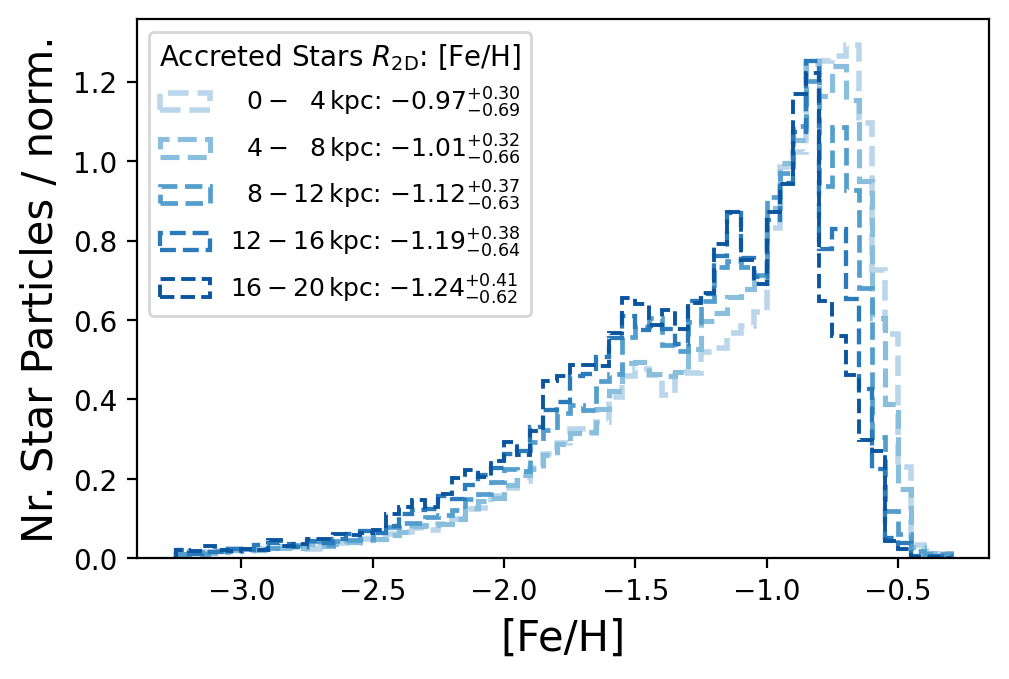

In [110]:
r_binsize = 4.0
r_edges = np.arange(0,20.1,r_binsize)
print(r_edges, len(r_edges))

f, ax = plt.subplots(figsize=(5.5,3.5))

cmap = matplotlib.colormaps['Blues']
norm = Normalize(vmin=-2, vmax=len(r_edges)-1)

for index, (r_left, r_right) in enumerate(zip(r_edges[:-1], r_edges[1:])):
    in_r_bin = (within_50kpc_born_outside_50kpc &
    (data['r_2d'] >= r_left) &
    (data['r_2d'] <  r_right)
    )

    percentile = np.round(np.percentile(data['Fe_H'][in_r_bin],q=[16,50,84]),2)
    distribution = "{:.2f}".format(percentile[1])+'_{-'+"{:.2f}".format(percentile[1]-percentile[0])+'}^{+'+"{:.2f}".format(percentile[2]-percentile[1])+r'}$'        

    if r_left < 10:
        r_left_txt = '~~'+str(int(r_left))
    else:
        r_left_txt = str(int(r_left))
    if r_right < 10:
        r_right_txt = '~~'+str(int(r_right))
    else:
        r_right_txt = str(int(r_right))

    # ax = gs[index]
    ax.hist(data['Fe_H'][in_r_bin],bins = np.arange(-3.25,-0.25,0.05),
        histtype='step',
        ls='dashed',
        lw=2.0-0.15*index,
        density=True,
        color=cmap(norm(index)),
        label = r'$'+r_left_txt+r'-'+r_right_txt+r'\,\mathrm{kpc}$: $'+distribution
    )

ax.legend(title=r'Accreted Stars $R_\mathrm{2D}$: [Fe/H]',fontsize=9,loc='upper left')
ax.set_xlabel('[Fe/H]',fontsize=15)
ax.set_ylabel('Nr. Star Particles / norm.',fontsize=15)

plt.savefig('figures/fe_h_histograms_r_bins.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()

In [ ]:
# How many stars do we actually expect in the inner galaxy, let's say within 3.6 kpc?  

f, gs = plt.subplots(3,1,figsize=(5,5),constrained_layout=True)

radius = 3.6 # kpc
height = 1.3 # kpc

within_r3p6_z_1p3 = (data['r_2d'] < radius) & (np.abs(data['z']) < 1.3)

fe_h_bins = np.arange(-2.55,0.55,0.025)
total_stars = len(data['Fe_H'])

ax = gs[0]
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

# Calculate Percentage of stars within 3D radius relative to the whole galaxy
fe_h_selected = data['Fe_H'][within_r3p6_z_1p3]
weights = 100*np.ones_like(fe_h_selected) / total_stars
frequency_within_radius = np.round(100*len(fe_h_selected)/total_stars)
ax.hist(
    fe_h_selected,
    bins=fe_h_bins,
    weights=weights,
    color='k',
    histtype='step',
    label=rf'$R_\mathrm{{2D}} < {radius}\,\mathrm{{kpc}}$, $\vert Z \vert < {height}\,\mathrm{{kpc}}$:'+'\n'+rf'${int(frequency_within_radius)}\%$ of star particles'
)

# Calculate Percentage of stars within 3D radius and born within 50kpc relative to the whole galaxy
fe_h_selected = data['Fe_H'][within_r3p6_z_1p3 & within_50kpc_born_within_50kpc]
weights = 100*np.ones_like(fe_h_selected) / total_stars
ax.hist(
    fe_h_selected,
    bins=fe_h_bins,
    weights=weights,
    color='C0',
    histtype='step',
    label=rf'As above and $R_\mathrm{{3D,birth}} < 50\,\mathrm{{kpc}}$:'+'\n'+rf'${int(np.round(100*len(fe_h_selected)/total_stars))}\%$ of star particles'
)

# Calculate Percentage of stars within 3D radius and born outside 50kpc relative to the whole galaxy
fe_h_selected = data['Fe_H'][within_r3p6_z_1p3 & within_50kpc_born_outside_50kpc]
weights = 100*np.ones_like(fe_h_selected) / total_stars
frequency_accreted_within_radius = 100.*len(fe_h_selected)/total_stars

ratio_accreted_inner_galaxy = r'$'+"{:.0f}".format(100*frequency_accreted_within_radius/frequency_within_radius)+r'\,\mathrm{\%}$'
with open("tex/ratio_accreted_inner_galaxy.tex", "w") as f:
    f.write(ratio_accreted_inner_galaxy+'%')

print(r'So for every 100 stars of the inner $R_\mathrm{2D} < '+str(radius)+r'\,\mathrm{kpc}$ and $\vert Z \vert < '+str(height)+r'\,mathrm{kpc}$ that we observe, we expect '+ratio_accreted_inner_galaxy+' to be of accreted origin')

ax.hist(
    fe_h_selected,
    bins=fe_h_bins,
    weights=weights,
    color='goldenrod',
    label=rf'As above but $R_\mathrm{{3D,birth}} > 50\,\mathrm{{kpc}}$:'+'\n'+rf'${np.round(frequency_accreted_within_radius,1)}\%$ of star particles'
)
ax.text(0.025,0.925,'a)',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.legend(loc=(0.09,0.225),fontsize=7)
ax.set_ylabel(r'Rel. Nr. / $\%$'+'\n (whole galaxy)',fontsize=13)

# Same as before, but now showing relative pattern
ax = gs[1]
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.hist(
    fe_h_selected,
    bins=fe_h_bins,
    weights=weights,
    color='goldenrod',
    label=rf'$R_\mathrm{{2D}} < {radius}\,\mathrm{{kpc}}$, $\vert Z \vert < {height}\,\mathrm{{kpc}}$,'+'\n'+rf'$R_\mathrm{{3D,birth}} > 50\,\mathrm{{kpc}}$:'+'\n'+rf'${np.round(100*len(fe_h_selected)/total_stars,1)}\%$ of star particles'
)
ax.text(0.025,0.925,'b)',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.legend(loc=(0.09,0.6),fontsize=7)
ax.set_ylabel(r'Rel. Nr. / $\%$'+'\n (whole galaxy)',fontsize=13)

# Same as before, but now showing relative pattern
ax = gs[2]
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
fe_h_selected = data['Fe_H']#[within_50kpc_born_outside_50kpc]
weights = 100*np.ones_like(fe_h_selected) / total_stars
ax.hist(
    fe_h_selected,
    bins=fe_h_bins,
    weights=weights,
    color='k',
    histtype='step',
    label=rf'All stars:'+'\n'+rf'${np.round(100*len(fe_h_selected)/total_stars,1)}\%$ of star particles'
)

fe_h_selected = data['Fe_H'][within_50kpc_born_outside_50kpc]
weights = 100*np.ones_like(fe_h_selected) / total_stars
ax.hist(
    fe_h_selected,
    bins=fe_h_bins,
    weights=weights,
    color='C3',
    label=rf'$R_\mathrm{{3D,birth}} > 50\,\mathrm{{kpc}}$:'+'\n'+rf'${np.round(100*len(fe_h_selected)/total_stars,1)}\%$ of star particles'
)
ax.text(0.025,0.925,'c)',fontsize=10,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.legend(loc=(0.09,0.485),fontsize=7)

ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=13)
ax.set_ylabel(r'Rel. Nr. / $\%$'+'\n (whole galaxy)',fontsize=13)
plt.savefig('figures/fe_h_histogram_inner_galaxy.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

In [ ]:
# And if we could do a pre-selection on [Fe/H]?

within_r3p6_z_1p3_fe_h = (data['r_2d'] < radius) & (np.abs(data['z']) < 1.3) & (data['Fe_H'] < -0.5)
within_r3p6_z_1p3_fe_h_accreted = (data['r_2d'] < radius) & (np.abs(data['z']) < 1.3) & (data['Fe_H'] < -0.5) & within_50kpc_born_outside_50kpc

ratio_accreted_inner_galaxy_with_feh_preselection = r'$'+"{:.0f}".format(100*len(data['r_2d'][within_r3p6_z_1p3_fe_h_accreted])/len(data['r_2d'][within_r3p6_z_1p3_fe_h]))+r'\,\mathrm{\%}$'
print('Ratio of accreted stars if preselected with [Fe/H] within R<3.6 and |Z| < 1.3kpc: '+ratio_accreted_inner_galaxy_with_feh_preselection)

with open("tex/ratio_accreted_inner_galaxy_with_feh_preselection.tex", "w") as f:
    f.write(ratio_accreted_inner_galaxy_with_feh_preselection+'%')


In [ ]:
pos_in_situ = np.vstack((
    data['x'][within_50kpc_born_within_50kpc], 
    data['y'][within_50kpc_born_within_50kpc], 
    data['z'][within_50kpc_born_within_50kpc]
)).T
bins = [np.linspace(-50, 50, 101)] * 3
H_in_situ, edges = np.histogramdd(pos_in_situ, bins=bins)

pos_accreted = np.vstack((
    data['x'][within_50kpc_born_outside_50kpc], 
    data['y'][within_50kpc_born_outside_50kpc], 
    data['z'][within_50kpc_born_outside_50kpc]
)).T
bins = [np.linspace(-50, 50, 101)] * 3
H_accreted, edges = np.histogramdd(pos_accreted, bins=bins)

with np.errstate(divide='ignore', invalid='ignore'):
    ratio = np.where(H_in_situ + H_accreted> 0, 100 * H_accreted / (H_in_situ + H_accreted), np.nan)

In [ ]:
# Get bin centers 
x_centers = 0.5 * (edges[0][1:] + edges[0][:-1])
y_centers = 0.5 * (edges[1][1:] + edges[1][:-1])
z_centers = 0.5 * (edges[2][1:] + edges[2][:-1])

# Define y slices
z_slices = [-5.0, -2.5, 0, 2.5, 5.0]
z_edges = edges[2]
dz = 0.5 # kpc
z_centers = 0.5 * (z_edges[1:] + z_edges[:-1])
z_index_ranges = [
    np.where((z_centers >= z0 - dz) & (z_centers <= z0 + dz))[0]
    for z0 in z_slices
]

# Prepare figure
fig, axes = plt.subplots(2,3, figsize=(10,6), sharex=True, sharey=True,constrained_layout=True)
axes = axes.flatten()
panels = ['a)','b)','c)','d)','e)','f)']

# Panel 0: full galaxy projection along y (average over y axis)
accreted_proj = np.sum(H_accreted, axis=2)
in_situ_proj   = np.sum(H_in_situ, axis=2)
with np.errstate(divide='ignore', invalid='ignore'):
    proj_ratio = np.where(in_situ_proj+accreted_proj > 0,  100*accreted_proj / (in_situ_proj+accreted_proj), np.nan)

im0 = axes[0].pcolormesh(
    x_centers, y_centers, proj_ratio.T,
    shading='auto', cmap='RdYlBu_r', vmin=0, vmax=100
)
axes[0].text(0.05,0.95,panels[0]+r' Average',fontsize=12,transform=axes[0].transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
axes[0].set_ylabel(r'$Y~/~\mathrm{kpc}$',fontsize=15)

# Panels 1–5: individual y slices
for i, (ax, z_val, z_range) in enumerate(zip(axes[1:], z_slices, z_index_ranges), start=1):
    slice_ratio = np.nanmean(ratio[:, :, z_range], axis=2)  # average over y_range
    im = ax.pcolormesh(
        x_centers, y_centers, slice_ratio.T,
        shading='auto', cmap='RdYlBu_r', vmin=0, vmax=100
    )
    ax.text(0.05,0.95,panels[i]+r' $Z='+str(z_val)+r'\pm'+str(dz)+r'\,\mathrm{kpc}$',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    if i in [3,4,5]:
        ax.set_xlabel(r'$X~/~\mathrm{kpc}$',fontsize=15)
    if i in [3]:
        ax.set_ylabel(r'$Y~/~\mathrm{kpc}$',fontsize=15)

# Add colorbar for all panels
cbar = fig.colorbar(im0, ax=axes)
cbar.set_label(r'Fraction of Accreted to In-situ+Accreted / $\%$',fontsize=15)
plt.savefig('figures/where_accretion_dominates_xy.png',dpi=200,bbox_inches='tight')
plt.show()


In [ ]:
# Get bin centers
x_centers = 0.5 * (edges[0][1:] + edges[0][:-1])
y_centers = 0.5 * (edges[1][1:] + edges[1][:-1])
z_centers = 0.5 * (edges[2][1:] + edges[2][:-1])

# Define y slices
y_slices = [-10, -5, 0, 5, 10]
y_edges = edges[1]
dy = 2.5 # kpc
y_centers = 0.5 * (y_edges[1:] + y_edges[:-1])
y_index_ranges = [
    np.where((y_centers >= y0 - dy) & (y_centers <= y0 + dy))[0]
    for y0 in y_slices
]

# y_indices = [np.argmin(np.abs(y_centers - y)) for y in y_slices]

# Prepare figure
fig, axes = plt.subplots(3,2, figsize=(12,6), sharex=True, sharey=True,constrained_layout=True)
axes = axes.flatten()
panels = ['a)','b)','c)','d)','e)','f)']

# Panel 0: full galaxy projection along y (average over y axis)
accreted_proj = np.sum(H_accreted, axis=1)  # shape (nx, nz)
in_situ_proj  = np.sum(H_in_situ, axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    proj_ratio = np.where(in_situ_proj+accreted_proj > 0,  100*accreted_proj / (in_situ_proj+accreted_proj), np.nan)

im0 = axes[0].pcolormesh(
    x_centers, z_centers, proj_ratio.T,
    shading='auto', cmap='RdYlBu_r', vmin=0, vmax=100
)
axes[0].text(0.025,0.925,panels[0]+r' Average',fontsize=12,transform=axes[0].transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
axes[0].set_ylabel(r'$Z~/~\mathrm{kpc}$',fontsize=15)

# Panels 1–5: individual y slices
for i, (ax, y_val, y_range) in enumerate(zip(axes[1:], y_slices, y_index_ranges), start=1):
    slice_ratio = np.nanmean(ratio[:, y_range, :], axis=1)  # average over y_range
    im = ax.pcolormesh(
        x_centers, z_centers, slice_ratio.T,
        shading='auto', cmap='RdYlBu_r', vmin=0, vmax=100
    )
    ax.text(0.025,0.925,panels[i]+r' $Y='+str(y_val)+r'\pm'+str(dy)+r'\,\mathrm{kpc}$',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    if i in [4,5]:
        ax.set_xlabel(r'$X~/~\mathrm{kpc}$',fontsize=15)
    if i in [2,4]:
        ax.set_ylabel(r'$Z~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylim(-17.5,17.5)

# Add colorbar for all panels
cbar = fig.colorbar(im0, ax=axes)
cbar.set_label(r'Fraction of Accreted to In-situ+Accreted / $\%$',fontsize=15)
plt.savefig('figures/where_accretion_dominates_xz.png',dpi=200,bbox_inches='tight')
plt.show()


In [ ]:
# Plot the birth positions of the 4 energy subsamples
f, gs = plt.subplots(1,4,figsize=(12,3))
for zone in [1,2,3,4]:
    ax = gs[zone-1]
    ax.set_title(
        [
            r'$E_{10^{5}} \geq '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[1])+r' \geq E_{10^{5}} < '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[0])+r' \geq E_{10^{5}} < '+str(energy_percentiles[1])+r'$',
            r'$'+str(energy_percentiles[0])+r' < E_{10^{5}}$'
        ][zone-1],fontsize=15
    )
    ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
    ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
    p = ax.hist2d(
        data['x_birth'][energy_zone[zone]],
        data['z_birth'][energy_zone[zone]],
        bins = (np.linspace(-200,100,200),np.linspace(-200,100,200)),
        cmin = 1,
        cmap = 'Reds_r',
        norm = LogNorm(vmax = 700)
    )
plt.tight_layout()
plt.show()
plt.close()

f, gs = plt.subplots(1,2,figsize=(8,3))

ax = gs[0]
ax.set_xlabel(r'$R_\mathrm{3D,birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'Nr. Star Particles',fontsize=15)
for zone in [1,2,3,4]:
    ax.hist(
        data['r_birth_3d'][energy_zone[zone]],
        bins = np.linspace(0,200,30),
        histtype='step',
        color = ['darkred','C3','C1','gold'][zone-1],
        label = [
            r'$\qquad\qquad\,\, E_{10^{5}} \geq '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[1])+r' \geq E_{10^{5}} < '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[0])+r' \geq E_{10^{5}} < '+str(energy_percentiles[1])+r'$',
            r'$'+str(energy_percentiles[0])+r' < E_{10^{5}}$'
        ][zone-1]
    )
ax.legend(fontsize=7,ncol=2);

ax = gs[1]
ax.set_xlabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'Nr. Star Particles',fontsize=15)
for zone in [1,2,3,4]:
    ax.hist(
        data['z_birth'][energy_zone[zone]],
        bins = np.linspace(-200,100,30),
        histtype='step',
        color = ['darkred','C3','C1','gold'][zone-1],
        label = [
            r'$\qquad\qquad\,\, E_{10^{5}} \geq '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[1])+r' \geq E_{10^{5}} < '+str(energy_percentiles[2])+r'$',
            r'$'+str(energy_percentiles[0])+r' \geq E_{10^{5}} < '+str(energy_percentiles[1])+r'$',
            r'$'+str(energy_percentiles[0])+r' < E_{10^{5}}$'
        ][zone-1]
    )
ax.legend(fontsize=7,ncol=2);

plt.tight_layout()
plt.show()
plt.close()

This does not really give a clear answer as to "where" the stars form, since they formed all around...  

Let's have a closer look at 2 regions here to better understand the connection of E and birth position

In [ ]:
# Plot 2D histograms at birth positions (-95,45) +- 32.5 kpc and color by present-day orbit energy
region1_xbirth = -95
region1_xscale = 32.5 # kpc around region1_xbirth
region1_ybirth = 45
region1_yscale = 32.5 # kpc around region1_xbirth

# Plot the birth positions of the 4 energy subsamples
f, ax = plt.subplots()
ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)

region_selection = (
    within_50kpc_born_outside_50kpc &
    (data['x_birth'] > region1_xbirth - region1_xscale) &
    (data['x_birth'] < region1_xbirth + region1_xscale) &
    (data['y_birth'] > region1_ybirth - region1_yscale) &
    (data['y_birth'] < region1_ybirth + region1_yscale)
)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    data['x_birth'][region_selection],
    data['y_birth'][region_selection],
    data['energy'][region_selection]/10**5,
    statistic='median',
    bins=(
        np.linspace(region1_xbirth - region1_xscale,region1_xbirth + region1_xscale,400),
        np.linspace(region1_ybirth - region1_yscale,region1_ybirth + region1_yscale,400)
    )
)
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.9, vmax = -0.2, cmap='autumn_r', zorder=1)
cbar = plt.colorbar(pcm,ax=ax,extend='both')
cbar.set_label(r'Energy $E~/~\mathrm{10^5\,\mathrm{kpc\,km\,s^{-1}}}$',fontsize=15)

ax.set_aspect('equal')
ax.text(0.05,0.95,'a)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
plt.tight_layout()
plt.savefig('figures/fellowship.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

In [ ]:
# Plot 2D histograms at birth positions (-10,5) +- 40 kpc and color by present-day orbit energy

region1_xbirth = -10
region1_xscale = 40 # kpc around region1_xbirth
region1_ybirth = 5
region1_yscale = 40 # kpc around region1_xbirth

# Plot the birth positions of the 4 energy subsamples
f, ax = plt.subplots()
ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)

ax.hist2d(
    data['x_birth'],
    data['y_birth'],
    bins=(
        np.linspace(region1_xbirth - region1_xscale,region1_xbirth + region1_xscale,400),
        np.linspace(region1_ybirth - region1_yscale,region1_ybirth + region1_yscale,400)
    ),
    cmin = 1,
    cmap = 'Greys',
    norm = LogNorm(vmax=500)
)

region_selection = (
    within_50kpc_born_outside_50kpc &
    (data['x_birth'] > region1_xbirth - region1_xscale) &
    (data['x_birth'] < region1_xbirth + region1_xscale) &
    (data['y_birth'] > region1_ybirth - region1_yscale) &
    (data['y_birth'] < region1_ybirth + region1_yscale)
)

stats, x_edge, y_edge, _ = binned_statistic_2d(
    data['x_birth'][region_selection],
    data['y_birth'][region_selection],
    data['energy'][region_selection]/10**5,
    statistic='median',
    bins=(
        np.linspace(region1_xbirth - region1_xscale,region1_xbirth + region1_xscale,400),
        np.linspace(region1_ybirth - region1_yscale,region1_ybirth + region1_yscale,400)
    )
)
stats[stats == 0] = np.nan
pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -0.9, vmax = -0.2, cmap='autumn_r', zorder=1)
cbar = plt.colorbar(pcm,ax=ax,extend='both')
cbar.set_label(r'Energy $E~/~\mathrm{10^5\,\mathrm{kpc\,km\,s^{-1}}}$',fontsize=15)

ax.set_aspect('equal')
ax.text(0.05,0.95,'b)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
plt.tight_layout()
plt.savefig('figures/mount_doom.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

## 3.4 Merger process and its chemodynamical effects

In [ ]:
# Have the "Splash" Stars really been splashed?

f, gs = plt.subplots(4,2,figsize=(7,7),sharex=True,sharey=True,constrained_layout=True)

feh_vphi_bins = (np.arange(-2.75,0.6,0.02),np.linspace(-295,395,200))

panels = ['a)','b)','c','d)','e)','f)','g)','h)']
panel_description = ['Row-normalised','All','In-situ','Accreted']

for index, selection in enumerate([within_50kpc, within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc]):
    
    if index == 0:
        ax = gs[index,0]
        ax.text(0.03,0.925,panels[index]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        H, xedges, yedges = np.histogram2d(
            data['Fe_H'][selection],
            data['vphi'][selection],
            bins = feh_vphi_bins
        )
        Hrow = H.copy()
        for row in range(np.shape(Hrow)[1]):
            Hrow[:,row] /= np.nanmax(Hrow[:,row])
        Hrow[Hrow==0] = np.nan
        ax.pcolormesh(xedges, yedges, Hrow.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like
        ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
        ax.axhline(0,lw=0.5,color='k')

        ax = gs[index,1]
        ax.text(0.03,0.925,panels[index+3]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

        H, xedges, yedges = np.histogram2d(
            data['Fe_H'][selection & galah_like],
            data['vphi'][selection & galah_like],
            bins = feh_vphi_bins
        )
        Hrow = H.copy()
        for row in range(np.shape(Hrow)[1]):
            Hrow[:,row] /= np.nanmax(Hrow[:,row])
        Hrow[Hrow==0] = np.nan
        ax.pcolormesh(xedges, yedges, Hrow.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like

    else:
        ax = gs[index,0]
        ax.text(0.03,0.925,panels[index]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        ax.hist2d(
            data['Fe_H'][selection],
            data['vphi'][selection],
            bins = feh_vphi_bins,
            cmin = 1,
            cmap = 'RdYlBu',
            norm = LogNorm()
        )
        ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
        if index == 3:
            ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
        ax.axhline(0,lw=0.5,color='k')

        ax = gs[index,1]
        ax.text(0.03,0.925,panels[index+3]+' '+panel_description[index],fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
        
        ax.hist2d(
            data['Fe_H'][selection & galah_like],
            data['vphi'][selection & galah_like],
            bins = feh_vphi_bins,
            cmin = 1,
            cmap = 'RdYlBu',
            norm = LogNorm()
        )

        if index == 1:
            ax.text(-2.73,-285,'A',va='bottom',ha='left',color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))

        if index == 2:
            rectangle = Rectangle((-2.74,-290),2.34,395-10+295,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            rectangle = Rectangle((-0.4,75),0.5,395-5-75,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            rectangle = Rectangle((0.1,75),0.48,395-5-75,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            rectangle = Rectangle((-0.4,-100),0.5,175,facecolor='None',alpha=0.95,linewidth=1.,edgecolor='k',ls='dashed')
            ax.add_artist(rectangle)
            
            ax.text(-2.72,-280,'E',va='bottom',ha='left',color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            ax.text(-0.38,380,'C',va='top',ha='left',color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            ax.text(+0.08,-90,'D',va='bottom',ha='right',color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            ax.text(+0.12, 380,'B',va='top',ha='left',color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))
            
        if index == 3:
            ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
            ax.text(-2.73,-285,'F',va='bottom',ha='left',color='w',bbox=dict(facecolor='grey', alpha=0.95, lw=0,pad=1))

            perc = np.round(np.percentile(data['vphi'][selection & galah_like],q=[16,50,84]),-1)
            perc_latex = r'$V_\varphi = '+"{:.0f}".format(perc[1])+'_{-'+"{:.0f}".format(perc[1]-perc[0])+'}^{+'+"{:.0f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{km\,s^{-1}}$'
            print('VPhi of accreted stars in Solar neighbourhood: '+perc_latex)
            with open("tex/splash_analysis_accreted_vphi.tex", "w") as f:
                f.write(perc_latex+'%')
                
    ax.axhline(0,lw=0.5,color='k')

gs[0,0].set_title(r'$R_\mathrm{3D} < 50\,\mathrm{kpc}$',fontsize=15)
gs[0,1].set_title(r'$'+str(galah_radius)+r'\,\mathrm{kpc}$ around $R_\mathrm{2D} = '+str(solar_radius)+r'\,\mathrm{kpc}$',fontsize=15)
plt.savefig('figures/splash_feh_vphi.png',dpi=200,bbox_inches='tight')
plt.show()

In [ ]:
# How Gaussian does the V_phi distribution look like? Is there a hint of something being splashed up?  
age_bins = [0,8,8.5,9,10,11,12,13,14]
feh_vphi_bins = (np.arange(-2.75,0.6,0.02),np.linspace(-295,395,200))

f, gs = plt.subplots(4,2,figsize=(7,6.5),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

for index, (age_min, age_max) in enumerate(zip(age_bins[:-1],age_bins[1:])):

    ax = gs[index]
    if index % 2 == 0:
        ax.set_ylabel(r'$V_\phi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
    if index >= len(age_bins)-3:
        ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
    ax.text(0.05,0.95,['a)','b)','c)','d)','e)','f)','g)','h)'][index]+' '+str(age_min)+'-'+str(age_max), transform=ax.transAxes, va='top', ha='left')
    
    ax.hist2d(
        data['Fe_H'][(data['age'] > age_min) & (data['age'] <= age_max)],
        data['vphi'][(data['age'] > age_min) & (data['age'] <= age_max)],
        bins = feh_vphi_bins,
        cmin = 1,
        norm = LogNorm(),
        cmap = 'RdYlBu'
    )

plt.show()

In [ ]:
# Where the splashed stars already born on these orbits?
f, gs = plt.subplots(2,1,figsize=(5,5.5),constrained_layout=True)

splashed = (data['vphi'] < 75) & (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1)

ax = gs[0]
ax.set_xlabel(r'$R_\mathrm{birth,2D}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
p = ax.hist2d(
    data['r_birth_2d'][splashed],
    data['z_birth'][splashed],
    bins = (np.linspace(0,15,200),np.linspace(-10,10,200)),
    cmin = 1,
    cmap = 'RdYlBu',
    vmax = 861
    #norm = LogNorm(vmax = 9801)
)
print(np.nanmax(p[0]))

perc = np.round(np.percentile(data['r_birth_2d'][splashed],q=[16,50,84]),2)
r2d_birth_latex = r'$R_\mathrm{birth,2D} = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
print('R2D birth', r2d_birth_latex)
with open("tex/r2d_birth_latex.tex", "w") as f:
    f.write(r2d_birth_latex+'%')
perc = np.round(np.percentile(data['z_birth'][splashed],q=[16,50,84]),2)
z_birth_latex = r'$Z_\mathrm{birth} = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
with open("tex/z_birth_latex.tex", "w") as f:
    f.write(z_birth_latex+'%')
print('z birth', z_birth_latex)

ax.text(0.02,0.95,r'a)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.text(0.975,0.95,r'Splash ($-0.4 < \mathrm{[Fe/H]} < 0.1$, $V_\varphi < 75\,\mathrm{km\,s^{-1}}$)'+'\n'+r2d_birth_latex+r', '+z_birth_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.text(0.975,0.95,r'Splash: '+r2d_birth_latex+r', '+z_birth_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

ax = gs[1]
ax.set_xlabel(r'$R_\mathrm{2D}~/~\mathrm{kpc}$',fontsize=15)
ax.set_ylabel(r'$Z~/~\mathrm{kpc}$',fontsize=15)
p = ax.hist2d(
    data['r_2d'][splashed],
    data['z'][splashed],
    bins = (np.linspace(0,15,200),np.linspace(-10,10,200)),
    cmin = 1,
    cmap = 'RdYlBu',
    vmax = 861
    #norm = LogNorm(vmax = 9801)
)
print(np.nanmax(p[0]))

perc = np.round(np.percentile(data['r_2d'][splashed],q=[16,50,84]),2)
r2d_latex = r'$R_\mathrm{2D} = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
with open("tex/r2d_latex.tex", "w") as f:
    f.write(r2d_latex+'%')
print('R2D now  ', r2d_latex)
perc = np.round(np.percentile(data['z'][splashed],q=[16,50,84]),2)
z_latex = r'$Z = '+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
with open("tex/z_latex.tex", "w") as f:
    f.write(z_latex+'%')
print('z now  ', z_latex)

ax.text(0.02,0.95,r'b)',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
# ax.text(0.975,0.95,r'Splash ($-0.4 < \mathrm{[Fe/H]} < 0.1$, $V_\varphi < 75\,\mathrm{km\,s^{-1}}$)'+'\n'+r2d_latex+r', '+z_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.text(0.975,0.95,r'Splash: '+r2d_latex+r', '+z_latex,fontsize=9,transform=ax.transAxes,va='top',ha='right',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))

plt.tight_layout()
cbar = plt.colorbar(p[-1], ax=gs, orientation='horizontal', pad=0.125)
cbar.set_label(r'Nr. Particles',fontsize=15)

plt.savefig('figures/splash_rz_birth_now.png',dpi=200,bbox_inches = 'tight')

plt.show()
plt.close()

print(' -> so outer disk (R > 4kpc) maybe splashed, but not so much the inner disk')
perc = np.round(np.percentile(np.abs(data['z_birth'][splashed]),q=[16,50,84]),2)
perc_latex = r'$'+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
print('|z| birth', perc_latex)
perc = np.round(np.percentile(np.abs(data['z'][splashed]),q=[16,50,84]),2)
perc_latex = r'$'+"{:.2f}".format(perc[1])+r'_{-'+"{:.2f}".format(perc[1]-perc[0])+r'}^{+'+"{:.2f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{kpc}$'
print('|z| now  ', perc_latex)
print(' -> not much change in vertical height since birth. Actually: scatter in |Z| decreased since birth!')

In [61]:
r2d_change = np.percentile(data['r_2d'][splashed] - data['r_birth_2d'][splashed],q=[16,50,84])
r2d_change = r'$\Delta R_\mathrm{2D} = '+"{:.1f}".format(r2d_change[1])+'_{-'+"{:.1f}".format(r2d_change[1]-r2d_change[0])+'}^{+'+"{:.1f}".format(r2d_change[2]-r2d_change[1])+r'}\,\mathrm{kpc}$'
z_change = np.percentile(np.abs(data['z'][splashed]) - np.abs(data['z_birth'][splashed]),q=[16,50,84])
z_change = r'$\Delta |Z| = '+"{:.2f}".format(z_change[1])+'_{-'+"{:.2f}".format(z_change[1]-z_change[0])+'}^{+'+"{:.2f}".format(z_change[2]-z_change[1])+r'}\,\mathrm{kpc}$'
with open("tex/splash_r2d_change.tex", "w") as f:
    f.write(r2d_change+'%')
with open("tex/splash_z_change.tex", "w") as f:
    f.write(z_change+'%')

print(' -> Splash median change in R2D: '+r2d_change)
print(' -> Splash median change in |Z|: '+z_change)

 -> Splash median change in R2D: $\Delta R_\mathrm{2D} = 0.1_{-1.1}^{+1.2}\,\mathrm{kpc}$
 -> Splash median change in |Z|: $\Delta |Z| = -0.03_{-0.70}^{+0.68}\,\mathrm{kpc}$


In [ ]:
# Age distribution of stars 

f, gs = plt.subplots(3,2,figsize=(7,5),sharex=True,sharey=True,constrained_layout=True)

feh_vphi_bins = (np.arange(-2.75,0.6,0.02),200)

for index, selection in enumerate([within_50kpc, within_50kpc_born_within_50kpc, within_50kpc_born_outside_50kpc]):
    ax = gs[index,0]
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['Fe_H'][selection],
        data['vphi'][selection],
        data['age'][selection],
        bins = feh_vphi_bins,
        statistic='median'
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = 0, vmax = 13.8, cmap='RdYlBu_r', zorder=1)
    ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)
    if index == 2:
        ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
    ax.axhline(0,lw=0.5,color='k')

    ax = gs[index,1]
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['Fe_H'][selection & galah_like],
        data['vphi'][selection & galah_like],
        data['age'][selection & galah_like],
        bins = feh_vphi_bins,
        statistic='median'
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = 0, vmax = 13.8, cmap='RdYlBu_r', zorder=1)
    if index == 2:
        ax.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)

    if index == 1:
        rectangle = Rectangle((-0.4,-100),0.5,175,facecolor='None',alpha=0.95,linewidth=1.5,edgecolor='k',ls='dashed')
        ax.add_artist(rectangle)
        
    ax.axhline(0,lw=0.5,color='k')
        
gs[0,0].set_title(r'$R_\mathrm{3D} < 50\,\mathrm{kpc}$',fontsize=15)
gs[0,1].set_title(r'$'+str(galah_radius)+r'\,\mathrm{kpc}$ around $R_\mathrm{2D} = '+str(solar_radius)+r'\,\mathrm{kpc}$',fontsize=15)
plt.savefig('figures/splash_feh_vphi_age.png',dpi=200,bbox_inches='tight')
plt.show()

In [ ]:
# Different selections of splash and surrounding areas: 

selections_and_names = [
    ['Solar Neighbourhood',
         galah_like
    ],
    ['In-situ metal-rich', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > 0.1)
    )],
    [r'In-situ $V_\varphi$ above Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > 75)
    )],
    ['In-situ Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > -100) & (data['vphi'] < 75)
    )],
    ['In-situ metal-poor', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] < -0.4)
    )],
    ['Accreted', (
        within_50kpc_born_outside_50kpc & galah_like
    )]
]

f, gs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

vmax = 886
rz_bins = (np.linspace(0,19.5,150),np.linspace(-9.75,9.75,150))

for index, (selection_name, selection) in enumerate(selections_and_names):
    
    ax = gs[index]
#     ax.set_aspect('equal')
    ax.text(0.05,0.95,panels[index]+' '+selection_name,fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    # p1 = ax.hist2d(
    #     data['r_birth_2d'][selection],
    #     data['z_birth'][selection],
    #     bins = rz_bins,
    #     norm = LogNorm(vmin=1,vmax = vmax),
    #     cmap = 'RdYlBu'
    # )
    p2 = ax.hist2d(
        data['r_2d'][selection],
        data['z'][selection],
        bins = rz_bins,
        norm = LogNorm(vmin=1,vmax = vmax),
        cmap = 'RdYlBu'
    )
    # print(np.max(p1[0]),np.max(p2[0]))
    print(np.max(p2[0]))

    print(index, np.round(np.percentile(data['r_birth_2d'][selection],q=[5,50,95]),1))
    
    circle = Circle((solar_radius,0),galah_radius,lw=1.5,edgecolor='w',facecolor='None')
    ax.add_artist(circle)
    circle = Circle((solar_radius,0),galah_radius,lw=1,edgecolor='k',facecolor='None')
    ax.add_artist(circle)
    # circle = Circle((solar_radius,-5),galah_radius,lw=1.5,edgecolor='w',facecolor='None')
    # ax.add_artist(circle)
    # circle = Circle((solar_radius,-5),galah_radius,lw=1,edgecolor='k',facecolor='None')
    # ax.add_artist(circle)
    if index >= 3:
        ax.set_xlabel(r'$R_\mathrm{2D}~/~\mathrm{kpc}$',fontsize=15)
    if index in [0,3]:
        ax.set_ylabel(r'$Z~/~\mathrm{kpc}$',fontsize=15)
    rect = Rectangle((11,-6),8,3,alpha=1,facecolor='w')
    ax.add_artist(rect)
    ax.text(8.2,-5,r'Now',fontsize=10,va='center',ha='center')
    ax.arrow(8.2, -4.1, 0, 1, width = 0.3, head_width=1, head_length=1, fc='C0', ec='darkblue',zorder=5)
    
cbar = plt.colorbar(p2[-1], ax=gs, location='right', pad=0.02)
cbar.set_label('Nr. Star Particles',fontsize=15)
plt.savefig('figures/splash_rbirth_zbirth_now.png',dpi=200,bbox_inches='tight')
plt.show()

In [ ]:
# Different selections of splash and surrounding areas: 

selections_and_names = [
    ['Solar Neighbourhood',
         galah_like
    ],
    ['In-situ metal-rich', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > 0.1)
    )],
    [r'In-situ $V_\varphi$ above Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > 75)
    )],
    ['In-situ Splash', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
        (data['vphi'] > -100) & (data['vphi'] < 75)
    )],
    ['In-situ metal-poor', (
        within_50kpc_born_within_50kpc & galah_like &
        (data['Fe_H'] < -0.4)
    )],
    ['Accreted', (
        within_50kpc_born_outside_50kpc & galah_like
    )]
]

f, gs = plt.subplots(2,3,figsize=(10,6),sharex=True,sharey=True,constrained_layout=True)
gs = gs.flatten()

vmax = 886
rz_bins = (np.linspace(0,19.5,150),np.linspace(-9.75,9.75,150))

for index, (selection_name, selection) in enumerate(selections_and_names):
    
    ax = gs[index]
#     ax.set_aspect('equal')
    ax.text(0.05,0.95,panels[index]+' '+selection_name,fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    p1 = ax.hist2d(
        data['r_birth_2d'][selection],
        data['z_birth'][selection],
        bins = rz_bins,
        norm = LogNorm(vmin=1,vmax = vmax),
        cmap = 'RdYlBu'
    )
    print(np.max(p1[0]),np.max(p2[0]))

    print(selections_and_names[index][0], np.round(np.percentile(data['r_birth_2d'][selection],q=[5,50,95]),1))
    
    circle = Circle((solar_radius,0),galah_radius,lw=1.5,edgecolor='w',facecolor='None')
    ax.add_artist(circle)
    circle = Circle((solar_radius,0),galah_radius,lw=1,edgecolor='k',facecolor='None')
    ax.add_artist(circle)
    if index >= 3:
        ax.set_xlabel(r'$R_\mathrm{2D,birth}~/~\mathrm{kpc}$',fontsize=15)
    if index in [0,3]:
        ax.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=15)
    rect = Rectangle((11,-6),8,3,alpha=1,facecolor='w')
    ax.add_artist(rect)
    ax.text(8.2,-5,r'Now',fontsize=10,va='center',ha='center',bbox=dict(facecolor='w', alpha=0.75,lw=0))
    ax.arrow(8.2, -4.1, 0, 1, width = 0.3, head_width=1, head_length=1, fc='C0', ec='darkblue',zorder=5)
    
cbar = plt.colorbar(p2[-1], ax=gs, location='right', pad=0.02)
cbar.set_label('Nr. Star Particles',fontsize=15)
plt.savefig('figures/splash_rbirth_zbirth.png',dpi=200,bbox_inches='tight')
plt.show()

In [ ]:
# How old are stars in splash compared to others (e.g. accreted ones)?
f, ax = plt.subplots(figsize=(5,4*5./6.))

#colors = ['k','darkred','C3','C1','gold','C0']
colors = ['k','darkblue','purple','C0','dodgerblue','C3']
name = ['A','B','C','D','E','F']
ls = ['dashed','solid','dashed','solid','solid','solid']
histtype = ['step','step','step','stepfilled','step','step']

for index, (selection_name, selection) in enumerate(selections_and_names):
    ax.hist(
        data['age'][selection],bins = np.arange(0,14,0.5),
        histtype=histtype[index],
        label = name[index]+' '+selection_name,
        color = colors[index],
        lw=1.5,
        ls = ls[index],
    )
    
    perc = np.round(np.percentile(data['age'][selection],q=[16,50,84]),1)
    perc_latex = r'$'+"{:.1f}".format(perc[1])+'_{-'+"{:.1f}".format(perc[1]-perc[0])+'}^{+'+"{:.1f}".format(perc[2]-perc[1])+'}'+r'\,\mathrm{Gyr}$'
    
    with open("tex/splash_analysis_age_sample_"+name[index]+".tex", "w") as f:
        f.write(perc_latex+'%')

    print(name[index],perc_latex)
    
ax.axvspan(8.6-0.2,8.6+0.2,facecolor='grey',alpha=0.5,zorder=0)
ax.legend(loc='upper left',fontsize=8)
ax.set_xlabel(r'$\mathrm{Age}~/~\mathrm{Gyr}$',fontsize=15)
ax.set_ylabel('Nr. Particles',fontsize=15)
plt.savefig('figures/splash_age.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Are the chemical signatures of the in-situ splash similar to the above splash?
f, ax = plt.subplots(figsize=(5,4*5./6.))

colors = ['k','darkred','C3','C1','gold','C0']
colors = ['k','darkblue','purple','C0','dodgerblue','C3']

for index, (selection_name, selection) in enumerate(selections_and_names):
    ax.hist(
        data['Mg_H'][selection]-data['Fe_H'][selection],bins = np.linspace(-0.2,0.2,100),
        histtype='step',
        label = selection_name,
        color = colors[index],
        lw = 1.5
    )
ax.legend(loc='upper right',fontsize=8)
ax.set_xlabel('[Mg/Fe]',fontsize=15)
ax.set_ylabel('Nr. Particles',fontsize=15)
plt.savefig('figures/splash_mgfe.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Are the chemical signatures of the in-situ splash similar to the above splash?
f, ax = plt.subplots(figsize=(5,4*5./6.))

colors = ['k','darkred','C3','C1','gold','C0']
colors = ['k','darkblue','purple','C0','dodgerblue','C3']

for index, (selection_name, selection) in enumerate(selections_and_names):
    ax.hist(
        data['Mn_H'][selection]-data['Fe_H'][selection],bins = np.linspace(-0.1,0.3,100),
        histtype='step',
        label = selection_name,
        color = colors[index],
        lw = 1.5
    )
ax.legend(loc='upper left')
ax.set_xlabel('[Mn/Fe]',fontsize=15)
ax.set_ylabel('Nr. Particles',fontsize=15)
plt.savefig('figures/splash_mnfe.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# And what are actions of the splashed vs. other stars -> did Belokurov also look into that?
f, gs = plt.subplots(1,3,figsize=(9,3))

colors = ['k','darkblue','purple','C0','dodgerblue','C3']

for index, (selection_name, selection) in enumerate(selections_and_names):
    if index > 0:
        ax = gs[0]
        ax.hist(
            data['JPhi'][selection],bins = np.arange(-1000,3000,100),
            histtype='step',color = colors[index],
            label = selection_name
        )
        ax.set_xlabel(r'$J_\phi~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
        ax.set_ylabel('Nr. Particles',fontsize=15)
        ax = gs[1]
        ax.hist(
            np.sqrt(data['JR'][selection]),bins = np.linspace(0,40,100),
            histtype='step',color = colors[index],
            label = selection_name
        )
        ax.set_xlabel(r'$\sqrt{J_R}~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
        ax.set_ylabel('Nr. Particles',fontsize=15)
        ax = gs[2]
        ax.hist(
            np.sqrt(data['JZ'][selection]),bins = np.linspace(0,25,100),
            histtype='step',color = colors[index],
            label = selection_name
        )
        ax.set_xlabel(r'$\sqrt{J_Z}~/~\mathrm{kpc\,km\,s^{-1}}$',fontsize=15)
        ax.set_ylabel('Nr. Particles',fontsize=15)
# ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
# Let's take a closer look at ages 9-11 Gyr in the -0.4 < [Fe/H] < 0.1 range
splash_9_11_gyr = (
    (data['age'] > 9) & 
    (data['age'] < 10) &
    within_50kpc_born_within_50kpc & galah_like &
    (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
    (data['vphi'] < 75)
)

above_splash_9_11_gyr = (
    (data['age'] > 9) & 
    (data['age'] < 10) &
    within_50kpc_born_within_50kpc & galah_like &
    (data['Fe_H'] > -0.4) & (data['Fe_H'] < 0.1) &
    (data['vphi'] >= 75)
)

In [ ]:
# Let's plot abundance distributions for all accreted stars and overplot the 68% contours for the 4 subsamples 

colors = ['darkblue','purple','C0','dodgerblue','C3']
colormaps = ['Blues','Purples']

def find_level_for_fraction(density, fraction):
    sorted_density = np.sort(density.ravel())[::-1]  # descending
    cumsum = np.cumsum(sorted_density)
    cumsum /= cumsum[-1]  # normalize to 1
    level_index = np.searchsorted(cumsum, fraction)
    return sorted_density[level_index]

zones = [1, 2, 3, 4]
name = ['A','B','C','D','E','F']

element = 'MgMn'

handles1 = []
handlesl1 = []
handles2 = []
handlesl2 = []

f, ax = plt.subplots(figsize=(5,4*5./6.))

all_density_maps = []
thresholds = []

ax_inset = inset_axes(ax,
width="22.5%",   # width relative to parent
height="32.5%",  # height relative to parent
loc='upper right',
bbox_to_anchor=(0.015, 0.015, 1, 1),
bbox_transform=ax.transAxes,
borderpad=1)

xdata = data['Al_H'] - data['Fe_H']
ydata = data['Mg_H'] - data['Mn_H']

ax_inset.text(0.03,0.01,r'$9-10\,\mathrm{Gyr}$',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.03,0.18,r'C',color='C4',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.14,0.18,r'/',color='k',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)
ax_inset.text(0.2,0.18,r'D',color='C0',transform=ax_inset.transAxes,va='bottom',ha='left',fontsize=8)

for subset, color in zip([splash_9_11_gyr,above_splash_9_11_gyr],colors):
    H, xedges, yedges = np.histogram2d(
        xdata[subset],
        ydata[subset],
        bins=(np.linspace(-0.09,0.05,50),np.linspace(-0.185,-0.08,50))
    )
    H_smooth = gaussian_filter(H, sigma=1.2)
    X, Y = np.meshgrid(
        0.5 * (xedges[:-1] + xedges[1:]),
        0.5 * (yedges[:-1] + yedges[1:])
    )
    ax_inset.contour(X, Y, H_smooth.T, levels=(1,5,10,20,), linewidths = (0.4,0.6,0.8,1.0), colors=color)
    # ax_inset.contour(X, Y, H.T, levels=(2,10,25), linewidths = (0.25,0.35,0.5), colors=color)
ax_inset.set_xticks([-0.075,0.025])

for index, (selection_name, selection) in enumerate(selections_and_names):
    # --- Define xdata, ydata, and bins ---
    if element == 'MgMn':
        xdata = data['Al_H'] - data['Fe_H']
        ydata = data['Mg_H'] - data['Mn_H']
        p1, p99 = np.percentile(ydata, q=[0.25, 99.75])
        bins = (np.linspace(-0.7, 0.275, 150), np.linspace(p1, p99, 150))
        ax.set_xlabel('[Al/Fe]',fontsize=15)
        ax.set_ylabel('[Mg/Mn]',fontsize=15)
    else:
        xdata = data['Fe_H']
        ydata = data[element+'_H'] - data['Fe_H']
        p1, p99 = np.percentile(ydata, q=[1, 99])
        bins = (np.linspace(-2.5, 0.65, 150), np.linspace(p1, p99, 150))
        ax.set_xlabel('[Fe/H]',fontsize=15)
        ax.set_ylabel('['+element+'/Fe]',fontsize=15)
        
    # --- Plot background hist2d (only once) ---
    if index == 0:
        h = ax.hist2d(
            xdata[selection],
            ydata[selection],
            bins=bins,
            cmin=1,
            cmap='Greys',
            norm=LogNorm(),
            label = 'A Solar Neighbourhood'
        )
        handles1.append(Patch(color='grey'))
        handlesl1.append('A Solar Neighbourhood')

    elif index > 0:
        s = ax.scatter(
            [np.median(xdata[selection])],
            [np.median(ydata[selection])],
            s = 100,zorder=5,
            marker = 'v',
            label = name[index]+' '+selection_name,
            color =colors[index-1]
        )         
        if index < 2:
            handles1.append(s)
            handlesl1.append(name[index]+' '+selection_name)
        else:
            handles2.append(s)
            handlesl2.append(name[index]+' '+selection_name)
        H, xedges, yedges = np.histogram2d(
            xdata[selection],
            ydata[selection],
            bins=bins
        )
        H_smooth = gaussian_filter(H, sigma=1.2)
        all_density_maps.append((H_smooth, xedges, yedges))

        # --- Get 68% level ---
        level_68 = find_level_for_fraction(H_smooth, 0.68)
        thresholds.append(level_68)
        
        # colors = ['darkred','C3','C1','gold','C0']
        colors = ['darkblue','purple','C0','dodgerblue','C3']

        X, Y = np.meshgrid(
            0.5 * (xedges[:-1] + xedges[1:]),
            0.5 * (yedges[:-1] + yedges[1:])
        )
        ax.contour(X, Y, H_smooth.T, levels=[level_68], colors=colors[index-1])
    
leg1 = ax.legend(handles1, handlesl1,loc='upper left',fontsize=8,columnspacing=0.5)
ax.add_artist(leg1)
ax.legend(handles2, handlesl2,loc='lower left',ncol=2,fontsize=8,columnspacing=0.5)

plt.tight_layout()
plt.savefig('figures/splash_alfe_mgmn.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()

In [ ]:
# Calculate the same figure as Belokurov et al. (2020).
f, gs = plt.subplots(1,3,figsize=(10,3),sharex=True,constrained_layout=True)

H, xedges, yedges = np.histogram2d(
    data['Fe_H'][galah_like],
    data['vphi'][galah_like],
    bins = (np.arange(-age_delta,0.5,0.02),np.linspace(-295,395,200))
)

ax = gs[0]
ax.text(0.05,0.95,r'a) $\log_{10}$ Density',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$\mathrm{[Fe/H}$', fontsize=15)
ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$', fontsize=15)
H0 = H.copy()
H0[H0==0] = np.nan
ax.pcolormesh(xedges, yedges, H0.T, shading='auto', cmap='Greys', norm=LogNorm())  # or any colormap you like

ax = gs[1]
ax.text(0.05,0.95,r'b) Column-normalised',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$\mathrm{[Fe/H}$', fontsize=15)
ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$', fontsize=15)
Hcol = H.copy()
for column in range(np.shape(Hcol)[0]):
    Hcol[column,:] /= np.nanmax(Hcol[column,:])
Hcol[Hcol==0] = np.nan
ax.pcolormesh(xedges, yedges, Hcol.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like

ax = gs[2]
ax.text(0.05,0.95,r'c) Row-normalised',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
ax.set_xlabel(r'$\mathrm{[Fe/H}$', fontsize=15)
ax.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$', fontsize=15)
Hrow = H.copy()
for row in range(np.shape(Hrow)[1]):
    Hrow[:,row] /= np.nanmax(Hrow[:,row])
Hrow[Hrow==0] = np.nan
ax.pcolormesh(xedges, yedges, Hrow.T, shading='auto', cmap='Greys')#, norm=LogNorm())  # or any colormap you like

plt.savefig('figures/splash_different_normalisations.png',dpi=200,bbox_inches='tight')

plt.show()
plt.close()

In [ ]:
# Let's show [Fe/H] vs. Vphi for the splash stars and calculate some stats
fig = plt.figure(constrained_layout=True)
gs = GridSpec(4, 4, figure=fig, hspace=0.05, wspace=0.05)

feh_bins = np.arange(-0.4,0.1,0.015)
vphi_bins = np.arange(-125,335,10)

# Define axes
ax_main = fig.add_subplot(gs[1:, :-1])     # bottom left large panel
ax_xhist = fig.add_subplot(gs[0, :-1], sharex=ax_main)  # top left small panel
ax_yhist = fig.add_subplot(gs[1:, -1], sharey=ax_main)  # bottom right small panel

# Plot main 2D histogram
ax_main.hist2d(
    data['Fe_H'][splash_9_11_gyr],
    data['vphi'][splash_9_11_gyr],
    bins = (feh_bins,vphi_bins),
    cmin = 1,
    cmap = 'Blues',
    label = r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$'
);
ax_main.hist2d(
    data['Fe_H'][above_splash_9_11_gyr],
    data['vphi'][above_splash_9_11_gyr],
    bins = (feh_bins,vphi_bins),
    cmin = 1,
    cmap = 'Purples',
    label = r'$V_\varphi \geq 75\,\mathrm{km\,s^{-1}}$coud'
);

# Plot top histogram (x)
ax_xhist.hist(
    [
        data['Fe_H'][splash_9_11_gyr | above_splash_9_11_gyr]
    ],
    bins = feh_bins,
    histtype = 'step',
    color = 'k',
    lw = 2,
#     label = r'$-0.4 < \mathrm{[Fe/H]} < 0.1$'+'\n& '+r'$9 < \mathrm{Age~/~Gyr} < 11$'
);
ax_xhist.hist(
    [
        data['Fe_H'][splash_9_11_gyr],
        data['Fe_H'][above_splash_9_11_gyr],
    ],
    bins = feh_bins,
    stacked = True,
    color = ['C0','C4'],
#     label = ['As above and\n'+r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$','As above and\n'+r'$V_\varphi > 75\,\mathrm{km\,s^{-1}}$']
);

# Plot right histogram (y)
ax_yhist.hist(
    [
        data['vphi'][splash_9_11_gyr | above_splash_9_11_gyr]
    ],
    bins = vphi_bins,
    histtype = 'step',
    color = 'k',
    lw = 2,
    orientation='horizontal'
    #label = r'$-0.4 < \mathrm{[Fe/H]} < 0.1$'+'\n& '+r'$9 < \mathrm{Age~/~Gyr} < 11$'
);
ax_yhist.hist(
    [
        data['vphi'][splash_9_11_gyr],
        data['vphi'][above_splash_9_11_gyr],
    ],
    bins = vphi_bins,
    stacked = True,
    color = ['C0','C4'],
    orientation='horizontal'
    #label = ['As above and\n'+r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$','As above and\n'+r'$V_\varphi > 75\,\mathrm{km\,s^{-1}}$']
);

ax_yhist.set_xlabel('Nr.',fontsize=15)
ax_xhist.set_ylabel('Nr.',fontsize=15,labelpad=11.5)

# Tidy up
ax_xhist.tick_params(labelbottom=False)
ax_yhist.tick_params(labelleft=False)

ax_main.set_xticks([-0.35,-0.25,-0.15,-0.05,0.05])
ax_main.set_yticks([-75,0,75,150,225,300])
ax_main.set_xlabel(r'$\mathrm{[Fe/H]}$',fontsize=15)
ax_main.set_ylabel(r'$V_\varphi~/~\mathrm{km\,s^{-1}}$',fontsize=15)


legend_patches = [
    Line2D([],[],color='k'),
    Patch(color='C0'),
    Patch(color='C4'),
]

legend_labels = [
    r'Sol. Neigh., $-0.4 < \mathrm{[Fe/H]} < 0.1$ & $9 < \mathrm{Age~/~Gyr} < 11$',
    r'$V_\varphi < 75\,\mathrm{km\,s^{-1}}$',
    r'$V_\varphi \geq 75\,\mathrm{km\,s^{-1}}$'
]

# Top right legend (just the first entry)
top_legend = ax_main.legend(
    handles=[legend_patches[0]],
    labels=[legend_labels[0]],
    loc='upper center',
    fontsize=8
)
ax_main.add_artist(top_legend)

# Bottom center legend (the last two entries)
bottom_legend = ax_main.legend(
    handles=legend_patches[1:],
    labels=legend_labels[1:],
    loc='lower center',
    ncol=2,
    fontsize=8
)

# Calculate some stats on the Vphi distribution
vphi_vals = data['vphi'][splash_9_11_gyr | above_splash_9_11_gyr]
mean_emp = np.mean(vphi_vals)
std_emp = np.std(vphi_vals)
skew_emp = skew(vphi_vals)
a_fit, loc_fit, scale_fit = skewnorm.fit(vphi_vals)
mean_fit = skewnorm.mean(a_fit, loc=loc_fit, scale=scale_fit)
std_fit = skewnorm.std(a_fit, loc=loc_fit, scale=scale_fit)
skew_fit = skewnorm.stats(a_fit, loc=loc_fit, scale=scale_fit, moments='s')

ax_yhist.text(0.95,0.875,rf'$\mu = {mean_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.925,rf'$\sigma = {std_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.975,rf'$\gamma_1 = {skew_emp:.2f}-{skew_fit:.2f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')

ax_yhist.text(0.95,0.175,rf'a$ = {a_fit:.2f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.125,rf'loc$ = {loc_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')
ax_yhist.text(0.95,0.075,rf'scale$ = {scale_fit:.0f}$',transform=ax_yhist.transAxes,fontsize=8,ha='right',va='top')

plt.savefig('figures/splash_vphi_distribution.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
datasets_for_testing = []
for selection in [(splash_9_11_gyr | above_splash_9_11_gyr),splash_9_11_gyr, above_splash_9_11_gyr]:
    datasets_for_testing.append(
        np.array([
            data['Al_H'][selection] - data['Al_H'][selection],
            data['Mg_H'][selection] - data['Mn_H'][selection]
        ]).T
    )

# stat, pval = Energy().test(datasets_for_testing[0], datasets_for_testing[1])
# print(f"Energy distance test: p = {pval:.3f}")

In [ ]:
from hyppo.ksample import MMD

stat, pval = MMD().test(datasets_for_testing[0], datasets_for_testing[1])
stat, pval

In [ ]:
from scipy import stats
print(stats.ks_2samp(datasets_for_testing[0], datasets_for_testing[1]))

### Tracking Star Formation during merger

In [ ]:
# Track Star Formation Density across 0.5 Gyr epochs

age_steps = 0.5
ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)

f, gs = plt.subplots(4,5,figsize=(8.75,6),sharex=True,sharey=True)
gs = gs.flatten()


for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    p = ax.hist2d(
        data['x_birth'][in_bin],
        data['y_birth'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-30,30,100)),
        cmin = 1,
        cmap = 'RdYlBu_r',
        norm = LogNorm(vmin=1,vmax=7580)
    )
    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr\n'+redshift_tex,transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    if index % 5 == 0:
        ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    
plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(p[-1], ax=gs, location='right', pad=0.02, aspect=30)
cbar.set_label('Nr. Star Particles',fontsize=12)

plt.savefig('figures/trace_star_formation_xy.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

f, gs = plt.subplots(4,5,figsize=(8.75,3.75),sharex=True,sharey=True)
gs = gs.flatten()

for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    p = ax.hist2d(
        data['x_birth'][in_bin],
        data['z_birth'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-15,15,100)),
        cmin = 1,
        cmap = 'RdYlBu_r',
        norm = LogNorm(vmin=1,vmax=6367)
    )

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    ax.text(0.95,0.05,redshift_tex,transform=ax.transAxes,fontsize=8,va='bottom',ha='right',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)

f.text(-0.005,0.575,r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12, va='center', ha='center', rotation='vertical')

plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(p[-1], ax=gs, location='right', pad=0.02, aspect=20)
cbar.set_label('Nr. Star Particles',fontsize=12)
plt.savefig('figures/trace_star_formation_xz.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Track Star Formation [Fe/H] across 0.5 Gyr epochs

age_steps = 0.5
ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)

print(len(ages))

f, gs = plt.subplots(4,5,figsize=(8.75,6),sharex=True,sharey=True)
gs = gs.flatten()


for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['y_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-30,30,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)
    
    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr\n'+redshift_tex,transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    if index % 5 == 0:
        ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    
plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=30, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xy_feh.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

f, gs = plt.subplots(4,5,figsize=(8.75,3.75),sharex=True,sharey=True)
gs = gs.flatten()

for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['z_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-15,15,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [age - age_steps/2.,age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    ax.text(0.95,0.05,redshift_tex,transform=ax.transAxes,fontsize=8,va='bottom',ha='right',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    
    if index >= len(ages) - 5:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)

f.text(-0.005,0.575,r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12, va='center', ha='center', rotation='vertical')

plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=20, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xz_feh.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()



In [ ]:
# Track Star Formation [Fe/H] across 0.5 Gyr epochs

age_steps = 0.5
# ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)

ages = np.array([0.0,3.5,8.0,8.5,9.0,9.5,10.0,10.5,11.5,12.5])+0.25

print(len(ages))

columns = 5
rows = 2

f, gs = plt.subplots(rows, columns, figsize=(8.75, 3.75), sharex=True, sharey=True)
gs = gs.flatten()


for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['y_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-30,30,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)
   
    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [(age - age_steps/2.).clip(min=0.001),age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr\n'+redshift_tex,transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    
    if index % columns == 0:
        ax.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    if index >= len(ages) - columns:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)
    
plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=30, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xy_feh_selection.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()

f, gs = plt.subplots(rows, columns,figsize=(8.75,2.5),sharex=True,sharey=True)
gs = gs.flatten()

for index, age in enumerate(ages[::-1]):
    ax = gs[index]
    ax.set_aspect('equal')
    in_bin = (
        within_50kpc & 
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )
    
    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin],
        data['z_birth'][in_bin],
        data['Fe_H'][in_bin],
        bins = (np.linspace(-30,30,100),np.linspace(-15,15,100)),
        statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin = -1.5, vmax = 0.5, cmap='RdYlBu_r', zorder=1)

    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [(age - age_steps/2.).clip(min=0.001),age + age_steps/2.]*u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z \sim {:.1f}$'.format(np.mean(redshifts))
        else:
            redshift_tex = r'$z \sim {:.2f}$'.format(np.mean(redshifts))
    else:
        if redshifts[0] > 1.0:
            redshift_tex = r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1])
        else:
            redshift_tex = r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1])

    ax.text(0.05,0.95,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='top',ha='left',bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))
    ax.text(0.05,0.05,"{:.1f}".format(np.round(age - age_steps/2.,2))+'-'+"{:.1f}".format(np.round(age + age_steps/2.,2))+'Gyr',transform=ax.transAxes,fontsize=8,va='bottom',ha='left')
    if index >= len(ages) - columns:
        ax.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12)

f.text(-0.005,0.575,r'$Z_\mathrm{birth}~/~\mathrm{kpc}$',fontsize=12, va='center', ha='center', rotation='vertical')

plt.tight_layout(w_pad=0,h_pad=0)
cbar = f.colorbar(pcm, ax=gs, location='right', pad=0.02, aspect=20, extend='both')
cbar.set_label('Star Formation [Fe/H]',fontsize=12)

plt.savefig('figures/trace_star_formation_xz_feh_selection.png',dpi=200,bbox_inches='tight')
plt.show()
plt.close()



In [ ]:
# --- Combined 5x4 panels: XY (rows 1 & 3, equal aspect) and XZ (rows 2 & 4, half-height) ---

age_steps = 0.5
# ages = np.arange(age_steps/2+3.5,13.8-age_steps/2,age_steps)
ages = np.array([0.0,3.5,8.0,8.5,9.0,9.5,10.0,10.5,11.5,12.5]) + 0.25  # length 10
assert len(ages) == 10, "This layout expects exactly 10 age bins."

# Layout plan:
# columns = 5
# rows = 4  (1: XY full, 2: XZ half, 3: XY full, 4: XZ half)
# top 2 rows use ages[::-1][:5] (most recent on left if you like); bottom 2 rows use ages[::-1][5:]

from matplotlib.gridspec import GridSpec

cols = 5
fig = plt.figure(figsize=(8.75, 6.5))  # taller to fit 4 rows nicely
gs = GridSpec(nrows=4, ncols=cols, figure=fig, height_ratios=[1.0, 0.5, 1.0, 0.5])

ages_rev = ages[::-1]
ages_top = ages_rev[:5]
ages_bot = ages_rev[5:]

# Predefine axis containers to share axes nicely
axes_xy_top = []
axes_xz_top = []
axes_xy_bot = []
axes_xz_bot = []

# Helper for the redshift text
def redshift_text(a_center, a_half):
    redshifts = z_at_value(Planck18.age, Planck18.age(0) - [(a_center - a_half).clip(min=0.001), a_center + a_half] * u.Gyr).value
    if np.abs(redshifts[0] - redshifts[1]) < 0.15:
        return (r'$z \sim {:.1f}$'.format(np.mean(redshifts)) if redshifts[0] > 1.0
                else r'$z \sim {:.2f}$'.format(np.mean(redshifts)))
    else:
        return (r'$z = {:.1f} - {:.1f}$'.format(redshifts[0], redshifts[1]) if redshifts[0] > 1.0
                else r'$z = {:.2f} - {:.2f}$'.format(redshifts[0], redshifts[1]))

# Common plotting params
xy_bins = (np.linspace(-30, 30, 100), np.linspace(-30, 30, 100))
xz_bins = (np.linspace(-30, 30, 100), np.linspace(-15, 15, 100))
vmin, vmax = -1.5, 0.5
cmap = 'RdYlBu_r'

# Track the last pcolormesh for colorbar
last_pcm = None

# ---------- TOP HALF: columns 0..4 with ages_top ----------
for c, age in enumerate(ages_top):
    # Row 1: XY (equal aspect)
    ax_xy = fig.add_subplot(gs[0, c]) if c == 0 else fig.add_subplot(gs[0, c], sharex=axes_xy_top[0], sharey=axes_xy_top[0])
    axes_xy_top.append(ax_xy)

    in_bin = (
        within_50kpc &
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )

    to_trace = np.where([((birth_overdensities[key][6]+1.3 > age - age_steps/2.) & (birth_overdensities[key][6]+0.7 < age + age_steps/2.)) for key in birth_overdensities.keys()])[0]
    print(age - age_steps/2.,age + age_steps/2., to_trace)

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['y_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xy_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xy.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm

    ax_xy.set_aspect(1)
    # Annotate: age window + z
    rz = redshift_text(age, age_steps/2.)
    ax_xy.text(0.05, 0.95,
               f"{np.round(age - age_steps/2.,2):.1f}-{np.round(age + age_steps/2.,2):.1f} Gyr\n{rz}",
               transform=ax_xy.transAxes, fontsize=8, va='top', ha='left',
               bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))

    if c == 0:
        ax_xy.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)
    ax_xy.tick_params(labelbottom=False)  # hide x labels on XY rows

    if len(to_trace) > 2:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], y_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xy.plot(d1_smooth, d2_smooth, 'k', lw=0.75, ls = 'dashed')
        ax_xy.set_xlim(x_edge[0], x_edge[-1])
        ax_xy.set_ylim(y_edge[0], y_edge[-1])
        ax_xy.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )

    # Row 2: XZ (half-height)
    ax_xz = fig.add_subplot(gs[1, c], sharex=axes_xy_top[0]) if c == 0 else fig.add_subplot(gs[1, c], sharex=axes_xy_top[0])
    axes_xz_top.append(ax_xz)

    stats, x_edge, z_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['z_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xz_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xz.pcolormesh(x_edge, z_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm

    ax_xz.set_aspect(1)

    if len(to_trace) > 2:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], z_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xz.plot(d1_smooth, d2_smooth, 'k', lw=0.75, ls = 'dashed')
        ax_xz.set_xlim(x_edge[0], x_edge[-1])
        ax_xz.set_ylim(z_edge[0], z_edge[-1])
        ax_xz.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )

    if c == 0:
        ax_xz.set_ylabel(r'$Z_\mathrm{birth}$', fontsize=12)
    ax_xz.tick_params(labelbottom=False)  # x labels only on very bottom row

# ---------- BOTTOM HALF: columns 0..4 with ages_bot ----------
for c, age in enumerate(ages_bot):
    # Row 3: XY (equal aspect)
    ax_xy = fig.add_subplot(gs[2, c], sharex=axes_xy_top[0], sharey=axes_xy_top[0])
    axes_xy_bot.append(ax_xy)

    in_bin = (
        within_50kpc &
        (data['age'] > age - age_steps/2.) &
        (data['age'] < age + age_steps/2.)
    )

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['y_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xy_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xy.pcolormesh(x_edge, y_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm

    ax_xy.set_aspect(1)
    rz = redshift_text(age, age_steps/2.)
    ax_xy.text(0.05, 0.95,
               f"{np.round(age - age_steps/2.,2):.1f}-{np.round(age + age_steps/2.,2):.1f} Gyr\n{rz}",
               transform=ax_xy.transAxes, fontsize=8, va='top', ha='left',
               bbox=dict(boxstyle='square', facecolor='w', alpha=0.5, lw=0))

    if c == 0:
        ax_xy.set_ylabel(r'$Y_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)
    ax_xy.tick_params(labelbottom=False)

    to_trace = np.where([((birth_overdensities[key][6]+1.2 > age - age_steps/2.) & (birth_overdensities[key][6]+0.85 < age + age_steps/2.)) for key in birth_overdensities.keys()])[0]
    print(age - age_steps/2.,age + age_steps/2., to_trace)

    if len(to_trace) > 3:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], y_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xy.plot(d1_smooth, d2_smooth, 'k', lw=0.75, ls = 'dashed')
        ax_xy.set_xlim(x_edge[0], x_edge[-1])
        ax_xy.set_ylim(y_edge[0], y_edge[-1])
        ax_xy.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )


    # Row 4: XZ (half-height)
    ax_xz = fig.add_subplot(gs[3, c], sharex=axes_xy_top[0])
    axes_xz_bot.append(ax_xz)

    stats, x_edge, z_edge, _ = binned_statistic_2d(
        data['x_birth'][in_bin], data['z_birth'][in_bin], data['Fe_H'][in_bin],
        bins=xz_bins, statistic='median',
    )
    stats[stats == 0] = np.nan
    pcm = ax_xz.pcolormesh(x_edge, z_edge, stats.T, shading='auto', vmin=vmin, vmax=vmax, cmap=cmap, zorder=1)
    last_pcm = pcm
    ax_xz.set_aspect(1)

    if c == 0:
        # ax_xz.set_ylabel(r'$Z_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)
        ax_xz.set_ylabel(r'$Z_\mathrm{birth}$', fontsize=12)
    # Bottom row gets x-labels
    ax_xz.set_xlabel(r'$X_\mathrm{birth}~/~\mathrm{kpc}$', fontsize=12)

    if len(to_trace) > 3:
        u_fine = np.linspace(0, 1, 500)
        tck, u_raw = splprep([x_trace[to_trace[0]:to_trace[-1]], z_trace[to_trace[0]:to_trace[-1]]], s=10, k=2)
        # if age == 8.75:
        #     tck, u_raw = splprep([np.concatenate((x_trace[to_trace[0]:to_trace[-1]],[0.0])), np.concatenate((z_trace[to_trace[0]:to_trace[-1]],[0.0]))], s=10, k=2)
        d1_smooth, d2_smooth = splev(u_fine, tck)
        ax_xz.plot(d1_smooth[50:], d2_smooth[50:], 'k', lw=0.75, ls = 'dashed')
        ax_xz.set_xlim(x_edge[0], x_edge[-1])
        ax_xz.set_ylim(z_edge[0], z_edge[-1])
        ax_xz.annotate(
        "", 
        xy=(d1_smooth[-1], d2_smooth[-1]),             # end point of arrow
        xytext=(d1_smooth[-2], d2_smooth[-2]),         # start point of arrow (just before end)
        arrowprops=dict(arrowstyle="->", color="k", lw=2),
    )

# Tight layout and single colorbar
plt.tight_layout(w_pad=0.0, h_pad=-12.5)
all_axes = axes_xy_top + axes_xz_top + axes_xy_bot + axes_xz_bot
cbar = fig.colorbar(last_pcm, ax=all_axes, location='right', pad=0.02, aspect=25, extend='both', fraction = 0.01925, anchor = (0.0,0.32))
cbar.set_label('Star Formation [Fe/H]', fontsize=12)

plt.savefig('figures/trace_star_formation_xy_xz_feh_selection.png', dpi=200, bbox_inches='tight')
plt.show()
plt.close()


# 4 Discussion

## Mass-Metallicity-Relation: Are we underestimating the "metallicity" part, because we haven't found the cores of the accreted systems?

In [ ]:
# Data from Naidu et al. (2022)
mzr_data_disrupted = dict()
mzr_data_disrupted['Sagittarius']            = [8.8,0.0,-0.86,0.03] # Note: while Table1 reports -0.96, the figures clearly use -0.86, which we use
mzr_data_disrupted['Gaia-Sausage_Enceladus'] = [8.7,0.0,-1.18,0.01]
mzr_data_disrupted['Helmi Streams'] = [8.0,0.0,-1.28,0.03]
mzr_data_disrupted['Sequoia'] = [7.2,0.0,-1.59,0.035]
mzr_data_disrupted['Wukong/LMS-1'] = [7.1,0.0,-1.58,0.045]
mzr_data_disrupted['Cetus'] = [7.0,0.0,-1.85,0.04]
mzr_data_disrupted['Thamnos'] = [6.7,0.0,-1.90,0.07]
mzr_data_disrupted["I'itoi"] = [6.3,0.0,-2.39,0.07]
mzr_data_disrupted['Orphan/Chenab'] = [6.1,0.0,-1.75,0.15]

# Data from Naidu et al. (2022) and Kirby et al (2013)
mzr_data_surviving = dict()
mzr_data_surviving['Large Magellanic Cloud'] = [9.4,0.0,-0.71,0.005]
mzr_data_surviving['Small Magellanic Cloud'] = [8.5,0.0,-1.08,0.005]
mzr_data_surviving['Fornax']            = [7.39,0.14,-1.04,0.33]
mzr_data_surviving['Leo I']             = [6.69,0.13,-1.45,0.33]
mzr_data_surviving['Sculptor']          = [6.59,0.21,-1.68,0.46]
mzr_data_surviving['Antlia 2']          = [6.2,0.0,-1.90,0.04]
mzr_data_surviving['Leo II']            = [6.07,0.13,-1.63,0.40]
mzr_data_surviving['Carina']            = [6.0,0.0,-1.72,0.01]
mzr_data_surviving['Sextans']           = [5.84,0.20,-1.94,0.47]
mzr_data_surviving['Ursa Minor']       = [5.73,0.20,-2.13,0.43]
mzr_data_surviving['Crater 2']       = [5.6,0.0,-2.16,0.04]
mzr_data_surviving['Draco']             = [5.51,0.10,-1.98,0.42]
mzr_data_surviving['Canes Venatici I']  = [5.48,0.09,-1.91,0.44]
# mzr_data_dsph['Hercules']          = [4.57,0.14,-2.39,0.51]
# mzr_data_dsph['Ursa Major I']      = [4.28,0.13,-2.10,0.65]
# mzr_data_dsph['Leo IV']            = [3.93,0.13,-2.45,0.65]
# mzr_data_dsph['Canes Venatici II'] = [3.90,0.20,-2.12,0.59]
# mzr_data_dsph['Ursa Major II']     = [3.73,0.23,-2.18,0.66]
# mzr_data_dsph['Coma Berenices']    = [3.68,0.22,-2.25,0.43]
# mzr_data_dsph['Segue 2']           = [3.14,0.13,-2.14,0.38]

# Data from Kirby et al. (2013)
mzr_data_localgroup = dict()
mzr_data_localgroup['NGC 6822']     = [7.92,0.09,-1.05,0.49]
mzr_data_localgroup['IC 1613 ']     = [8.01,0.06,-1.19,0.37]
mzr_data_localgroup['VV 124 ']      = [6.92,0.08,-1.43,0.52]
mzr_data_localgroup['Pegasus dIrr'] = [6.82,0.08,-1.39,0.56]
mzr_data_localgroup['Leo A']        = [6.47,0.09,-1.58,0.42]
mzr_data_localgroup['Aquarius']     = [6.15,0.05,-1.44,0.35]
mzr_data_localgroup['Leo T']        = [5.13,0.20,-1.74,0.54]


In [ ]:
# Where would different selections of the Major Merger end up in a Mass-Metallicity Relation?

colors = ['k','grey','darkgrey']
group_names = ['Disrupted Dwarf galaxies','Surviving Dwarf galaxies','Local Group Dwarf Irregulars']
marker = ['*','s','h']
size = [10,5,5]

legend_lines = []
legend_labels = []

fig = plt.figure(figsize=(6, 4),constrained_layout=True)
gs = GridSpec(1, 2, width_ratios=[6, 1], wspace=0.05)
ax = fig.add_subplot(gs[0])

for group_index, group in enumerate([mzr_data_disrupted, mzr_data_surviving, mzr_data_localgroup]):
    for galaxy_index, galaxy in enumerate(group.keys()):
        if galaxy_index == 0:
            label = group_names[group_index]
        else:
            label = '_nolegend_'
        s = ax.errorbar(
            [group[galaxy][0]],
            [group[galaxy][2]],
            xerr = [[group[galaxy][1]]],
            yerr = [[group[galaxy][3]]],
            fmt = marker[group_index],
            c = colors[group_index],
            #capsize=1,
            lw = 0.3,
            ms = size[group_index],
            label = label
        )
        if galaxy_index == 0:
            legend_lines.append(s)
            legend_labels.append(group_names[group_index])
    
def kirby2013_mzr(logMass):
    return(-1.69 + 0.30 * (logMass-6))
    
# Kirby et al. (2013) MZR
s, = ax.plot(
    np.linspace(5.,9.8,10),
    kirby2013_mzr(np.linspace(5.,9.8,10)),
    c = 'k',
    lw = 1,
    ls = 'dashed',
    label = 'MZR Kirby et al. (2013)'
)
legend_lines.append(s)
legend_labels.append('MZR (Dwarfs) Kirby+2013')

s, = ax.plot(
    np.linspace(5.,9.8,10),
    kirby2013_mzr(np.linspace(5.,9.8,10))-0.3,
    c = 'k',
    lw = 0.5,
    ls = 'dashed',
    label = 'Naidu et al. (2022)'
)
legend_lines.append(s)
legend_labels.append('MZR (Disrupted) Naidu+2022')

ax.set_xlim(4.9,9.9)
ax.set_xlabel(r'$\log_{10}(M_\bigstar~/~\mathrm{M_\odot})$',fontsize=15)
ax.set_ylabel(r'$\mathrm{[Fe/H]}$',fontsize=15)

ax_hist = fig.add_subplot(gs[1], sharey=ax)
ax_hist.yaxis.tick_right()
ax_hist.yaxis.set_label_position("right")
ax_hist.set_xlabel('Density',fontsize=15)
ax_hist.set_xlim(0,1.25)
ax_hist.set_xticks([0,0.5,1.0])
ax_hist.set_ylim(-2.75,-0.35)
ax_hist.set_ylabel(r'$\mathrm{[Fe/H]}$',fontsize=15)

first_legend = ax.legend(legend_lines[:5], legend_labels[:5], loc='upper left',fontsize=8)

plt.tight_layout()
plt.savefig('figures/mzr_different_selections_1.png',dpi=200,bbox_inches='tight',facecolor='w')

s = ax.scatter(
    [np.log10(np.sum(data['mass'][within_50kpc_born_outside_50kpc]))],
    [np.median(data['Fe_H'][within_50kpc_born_outside_50kpc])],
    c = 'royalblue',
    s = 200,
    zorder = 3,
#     label = 'Sim. Maj.Mer. Median [Fe/H]'
)
legend_lines.append(s)
legend_labels.append('Median [Fe/H] of NIHAO-UHD Merger      ')
ax.add_artist(first_legend)  # This is important to keep the first legend
second_legend = ax.legend(legend_lines[5:], legend_labels[5:], loc='lower right',fontsize=8,handler_map={tuple: HandlerTuple(ndivide=None)})

ax_hist.hist(
    data['Fe_H'][within_50kpc_born_outside_50kpc],
    bins=np.linspace(-2.75,-0.35,50),
    orientation='horizontal',
    color = 'royalblue',
    histtype='step',
    density=True,
    lw=1.5
)

plt.savefig('figures/mzr_different_selections_2.png',dpi=200,bbox_inches='tight',facecolor='w')


for zone in [1,2,3,4]:
    ax.scatter(
        [np.log10(np.sum(data['mass'][within_50kpc_born_outside_50kpc]))],
        [np.median(data['Fe_H'][energy_zone[zone]])],
        c = ['darkred','C3','C1','gold'][zone-1],
        s = 30*zone,
        zorder = 3
    )
legend_markers = (
    Line2D([], [], marker='o', color='darkred', linestyle='None', markersize=8),
    Line2D([], [], marker='o', color='C3',      linestyle='None', markersize=8),
    Line2D([], [], marker='o', color='C1',      linestyle='None', markersize=8),
    Line2D([], [], marker='o', color='gold',    linestyle='None', markersize=8),
)
legend_lines.append(legend_markers)
legend_labels.append('Median [Fe/H] per $E$-Zone, Total Mass    ')
second_legend = ax.legend(legend_lines[5:][::-1], legend_labels[5:][::-1], loc='lower right',fontsize=8,handler_map={tuple: HandlerTuple(ndivide=None)})

ax_hist.hist(
    [data['Fe_H'][energy_zone[zone]] for zone in [1,2,3,4]],
    bins=np.linspace(-2.75,-0.35,50),
    orientation='horizontal',
    color = ['darkred','C3','C1','gold'],
    stacked = True,
    density=True
)

plt.savefig('figures/mzr_different_selections_3.png',dpi=200,bbox_inches='tight',facecolor='w')
 
for zone in [1,2,3,4]:
    ax.scatter(
        [np.log10(np.sum(data['mass'][energy_zone[zone]]))],
        [np.median(data['Fe_H'][energy_zone[zone]])],
        c = ['darkred','C3','C1','gold'][zone-1],
        marker = 'v',
        s = 30*zone,
        zorder = 3
    )

legend_markers = (
    Line2D([], [], marker='v', color='darkred', linestyle='None', markersize=8),
    Line2D([], [], marker='v', color='C3',      linestyle='None', markersize=8),
    Line2D([], [], marker='v', color='C1',      linestyle='None', markersize=8),
    Line2D([], [], marker='v', color='gold',    linestyle='None', markersize=8),
)
legend_lines.append(legend_markers)
legend_labels.append('Median [Fe/H] per $E$-Zone, $E$-Zone Mass')
second_legend = ax.legend(legend_lines[5:][::-1], legend_labels[5:][::-1], loc='lower right',fontsize=8,handler_map={tuple: HandlerTuple(ndivide=None)})

plt.savefig('figures/mzr_different_selections.png',dpi=200,bbox_inches='tight',facecolor='w')
plt.show()
plt.close()